# Analyze AFM tip solvation

This notebook demonstrates deposition of an SDS adsorption layer on a non-spherical AFM tip model.

## Initialization

### IPython magic

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



### Imports

In [2]:
import ase.io # here used for reading pdb files
from ase.visualize import view
from ase.visualize.plot import plot_atoms # has nasty offset issues
from cycler import cycler # here used for cycling through colors in plots
import datetime
import fabric # for pythonic ssh connections
from fireworks import LaunchPad, Firework, Tracker, Workflow 
from fireworks import FileTransferTask, PyTask, ScriptTask

# FireWorks functionality 
from fireworks import Firework, LaunchPad, ScriptTask, Workflow
from fireworks.user_objects.firetasks.templatewriter_task import TemplateWriterTask
from fireworks.user_objects.firetasks.filepad_tasks import AddFilesTask, GetFilesTask, GetFilesByQueryTask
from imteksimfw.fireworks.user_objects.firetasks.cmd_tasks import CmdTask
from fireworks.utilities.filepad import FilePad # direct FilePad access, similar to the familiar LaunchPad

import glob
import gc # manually clean up memory with gc.collect()
import gromacs # GromacsWrapper, here used for evoking gmc commands, reading and writing .ndx files
# from io import StringIO, TextIOWrapper
import io
from IPython.display import display, Image #, Video # display image files within notebook
from ipywidgets import Video  # display video within notebook
import itertools # for products of iterables
import json # generic serialization of lists and dicts
import jinja2 # here used for filling packmol input script template
import jinja2.meta # for gathering variables in a jinja2 template
import logging 
import matplotlib.pyplot as plt
import MDAnalysis as mda # here used for reading and analyzing gromacs trajectories
import MDAnalysis.analysis.rdf as mda_rdf
import MDAnalysis.analysis.rms as mda_rms
from mpl_toolkits.mplot3d import Axes3D # here used for 3d point cloud scatter plot
import miniball # finds minimum bounding sphere of a point set
import nglview
import numpy as np
import os, os.path
import pandas as pd
import panedr # reads GROMACS edr into pandas df, requires pandas and pbr
import parmed as pmd # has quite a few advantages over ASE when it comes to parsing pdb
from pprint import pprint
import pymongo # for sorting in queries
import scipy.constants as sc
import subprocess # used for evoking external packmol
import sys
import tempfile
import yaml

NOTE: Some configuration directories are not set up yet: 
	/home/centos/.gromacswrapper
	/home/centos/.gromacswrapper/qscripts
	/home/centos/.gromacswrapper/templates
NOTE: You can create the configuration file and directories with:
	>>> import gromacs
	>>> gromacs.config.setup()


GromacsWrapper might need a file `~/.gromacswrapper.cfg` with content
```cfg
[Gromacs]
tools = gmx gmx_d 
# gmx_mpi_d gmx_mpi_d

# name of the logfile that is written to the current directory
logfilename = gromacs.log

# loglevels (see Python's logging module for details)
#   ERROR   only fatal errors
#   WARN    only warnings
#   INFO    interesting messages
#   DEBUG   everything

# console messages written to screen
loglevel_console = INFO

# file messages written to logfilename
loglevel_file = DEBUG
```
in order to know the GROMACS executables it is allowed to use. Otherwise,
calls to `gmx_mpi` or `gmx_mpi_d` without MPI wrapper might lead to MPI 
warnings in output that cause GromacsWrapper to fail.

### Logging

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

ParmEd needs to know the GROMACS topology folder, usually get this from 
envionment variable `GMXLIB`:

### Function definitions

In [4]:
def find_undeclared_variables(infile):
    """identify all variables evaluated in a jinja 2 template file"""
    env = jinja2.Environment()
    with open(infile) as template_file:
        parsed = env.parse(template_file.read())

    undefined = jinja2.meta.find_undeclared_variables(parsed)
    return undefined

In [5]:
def memuse():
    """Quick overview on memory usage of objects in Jupyter notebook"""
    # https://stackoverflow.com/questions/40993626/list-memory-usage-in-ipython-and-jupyter
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    return sorted([(x, sys.getsizeof(globals().get(x))) for x in dir(sys.modules['__main__']) if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

### Global settings

In [6]:
 # os.environ['GMXLIB']

In [7]:
# pmd.gromacs.GROMACS_TOPDIR = os.environ['GMXLIB']
pmd.gromacs.GROMACS_TOPDIR = '/usr/share/gromacs/top'

In [8]:
# prefix = '/mnt/dat/work/testuser/indenter/sandbox/20191110_packmol'
prefix = '/home/jotelha/git/jlhphd'

In [9]:
work_prefix = '/home/jotelha/tmp/20200421_fw/'

In [10]:
try:
    os.mkdir(work_prefix)
except FileExistsError as exc:
    print(exc)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jotelha/tmp/20200421_fw/'

In [ ]:
os.chdir(work_prefix)

In [ ]:
# the FireWorks LaunchPad
lp = LaunchPad.auto_load() #Define the server and database
# FilePad behaves analogous to LaunchPad
fp = FilePad.auto_load()

## Conversion from LAMMPS data format to PDB

The vollowing bash / tcl snippet converts a LAMMPS data file to PDB, assigning the desired names as mapped in a yaml file
```bash
#!/bin/bash
# echo "package require jlhvmd; jlh lmp2pdb indenter.lammps indenter.pdb" | vmd -eofexit
vmd -eofexit << 'EOF'
package require jlhvmd
topo readlammpsdata indenter.lammps
jlh type2name SDS_type2name.yaml
jlh name2res  SDS_name2res.yaml
set sel [atomselect top all]
$sel writepdb indenter.pdb
EOF

pdb_chain.py indenter.pdb > indenter_wo_chainid.pdb
pdb_reres_by_atom_9999.py indenter_wo_chainid.pdb > indenter_reres.pdb
```

Requires

* VMD (tested with 1.9.3) with topotools
* jlhvmd VMD plugin: https://github.com/jotelha/jlhvmd
* pdb-tools: https://github.com/haddocking/pdb-tools/

## Overview

### Overview on projects in database

In [25]:
query = {'metadata.datetime': {'$gt': '2020'} }

In [26]:
fp.filepad.count_documents(query)

849

In [27]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 'project': '$metadata.project' },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # pull 'project' field up in hierarchy
        "$addFields": { 
            "project": "$_id.project",
        },
    },
    {  # drop nested '_id.project'
        "$project": { 
            "_id": False 
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

# sort_aggregation
#aggregation_pipeline = [ match_aggregation, group_aggregation, set_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [c for c in cursor]
res_df = pd.DataFrame(data=res) # pandas Dataframe is just nice for printing in notebook

In [28]:
res_df

object_count                    earliest                      latest  \
0            276  2020-05-08 17:40:43.151560  2020-05-08 20:09:19.785964   
1              8  2020-05-08 16:46:54.125267  2020-05-08 16:46:55.061579   
2            102  2020-05-06 19:57:34.090873  2020-05-06 23:02:33.696573   
3              4  2020-05-04 19:56:27.458671  2020-05-04 19:56:27.458686   
4              1  2020-05-04 17:47:46.398832  2020-05-04 17:47:46.398832   
5             15  2020-04-29 20:03:40.694070  2020-04-29 21:43:41.499280   
6            102  2020-04-23 00:42:50.738462  2020-04-23 12:29:04.927501   
7              6  2020-04-22 23:52:50.724373  2020-04-22 23:52:50.724774   
8             30  2020-04-22 20:12:52.975107  2020-04-22 20:12:52.992097   
9             12  2020-04-22 15:35:33.694291  2020-04-22 19:37:27.812809   
10            23  2020-04-22 00:22:22.239748  2020-04-22 00:22:22.241080   
11             2  2020-04-21 21:08:51.961011  2020-04-21 21:08:51.961024   
12            42  2020-04-21 17:33:16.919815  2020-04-21 23:19:49.893920   
13             7  2020-04-21 15:35:02.223005  2020-04-21 15:35:02.223026   
14            15  2020-04-15 12:12:58.569894  2020-04-21 14:39:06.617272   
15            74  2020-04-15 01:58:21.918222  2020-04-21 13:38:43.462681   
16             4  2020-04-15 00:28:04.783910  2020-04-15 00:28:04.783995   
17             3  2020-04-14 21:19:31.298223  2020-04-14 21:19:31.298232   
18             2  2020-04-14 17:14:15.144625  2020-04-14 20:23:20.587799   
19             2  2020-04-03 01:25:09.142195  2020-04-07 16:18:42.232568   
20             5  2020-04-02 21:18:13.804918  2020-04-12 20:56:30.319559   
21            39  2020-03-25 12:11:11.906332  2020-03-25 22:47:26.604903   
22             8  2020-03-13 12:33:31.922163  2020-03-13 12:33:31.922497   
23            10  2020-03-12 12:31:29.329732  2020-03-12 15:55:54.013161   
24            42  2020-03-11 18:45:59.775161  2020-03-12 00:15:43.047626   
25            15  2020-03-09 18:13:09.455387  2020-03-09 23:30:45.006483   

                                          project  
0                                2020-05-08-final  
1                          2020-05-08-dtool-trial  
2           2020-05-06-indenter-passivation-trial  
3                   2020-05-04-gmx-em-dtool-trial  
4                        2020-04-29-gmx-nvt-trial  
5                        2020-04-23-gmx-nvt-trial  
6           2020-04-23-indenter-passivation-trial  
7                        2020-04-22-gmx-nvt-trial  
8                   2020-04-22-intermediate-trial  
9           2020-04-22-trajectory-rendering-trial  
10                  2020-04-21-gmx-chain-wf-trial  
11                   2020-04-21-gmx-solvate-trial  
12                  2020-04-21-intermediate-trial  
13                      2020-04-21-gmx-pull-trial  
14                 2020-04-15-gmx-pull-prep-trial  
15                  2020-04-15-intermediate-trial  
16                        2020-04-15-gmx-em-trial  
17                      2020-04-14-gmx-prep-trial  
18                       2020-04-14-packmol-trial  
19  2020-04-02-surfactant-molecule-measures-trial  
20                         2020-03-31-local-trial  
21                         juwels-pull-2020-03-17  
22  juwels-afm-probe-solvation-trial-a-2020-03-13  
23                   juwels-gromacs-em-2020-03-12  
24                 juwels-gromacs-prep-2020-03-11  
25                      juwels-packmol-2020-03-09

### Overview on steps in project

In [29]:
project_id = '2020-05-08-final'

In [30]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [31]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

288

In [32]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [33]:
res_df

step  \
0   GromacsSolvate:ProcessAnalyzeAndVisualize:push...   
1   GromacsNPTEquilibration:ProcessAnalyzeAndVisua...   
2   GromacsNVTEquilibration:ProcessAnalyzeAndVisua...   
3   GromacsEnergyMinimizationAfterSolvation:Proces...   
4    GromacsSolvate:ProcessAnalyzeAndVisualize:pus...   
5   GromacsPull:ProcessAnalyzeAndVisualize:push_fi...   
6   GromacsPullPrep:ProcessAnalyzeAndVisualize:pus...   
7   GromacsEnergyMinimization:ProcessAnalyzeAndVis...   
8   GromacsPrep:ProcessAnalyzeAndVisualize:push_fi...   
9   SphericalSurfactantPacking:ProcessAnalyzeAndVi...   
10  PackingConstraintSpheres:ProcessAnalyzeAndVisu...   
11  SurfactantMoleculeMeasures:ProcessAnalyzeAndVi...   
12  IndenterBoundingSphere:ProcessAnalyzeAndVisual...   
13  GromacsEnergyMinimization:GromacsEnergyMinimiz...   
14            SphericalSurfactantPacking:push_infiles   
15  SurfactantMoleculeMeasures:SurfactantMoleculeM...   
16   GromacsPullPrep:GromacsPullPrepMain:push_infiles   
17  IndenterBoundingSphere:IndenterBoundingSphereM...   
18  GromacsEnergyMinimization:GromacsTrajectoryVis...   
19  GromacsEnergyMinimizationAfterSolvation:Gromac...   
20  GromacsNVTEquilibration:GromacsNVTEquilibratio...   
21  GromacsNPTEquilibration:GromacsNPTEquilibratio...   

                      earliest                      latest  object_count  
0   2020-05-08 20:09:19.751032  2020-05-08 20:09:19.751037             2  
1   2020-05-08 17:40:43.318376  2020-05-08 20:09:19.785964            42  
2   2020-05-08 17:40:43.307572  2020-05-08 20:09:19.773631            42  
3   2020-05-08 17:40:43.297276  2020-05-08 20:09:19.760954            40  
4   2020-05-08 17:40:43.289644  2020-05-08 17:40:43.289649             2  
5   2020-05-08 17:40:43.286971  2020-05-08 20:09:19.747773            46  
6   2020-05-08 17:40:43.279414  2020-05-08 20:09:19.737666            12  
7   2020-05-08 17:40:43.276660  2020-05-08 20:09:19.734068            57  
8   2020-05-08 17:40:43.268891  2020-05-08 20:09:19.721587             9  
9   2020-05-08 17:40:43.260666  2020-05-08 20:09:19.708894             6  
10  2020-05-08 17:40:43.228992  2020-05-08 20:09:19.665059             6  
11  2020-05-08 17:40:43.196240  2020-05-08 20:09:19.623817             6  
12  2020-05-08 17:40:43.151560  2020-05-08 20:09:19.562982             6  
13                        None                        None             1  
14                        None                        None             2  
15                        None                        None             1  
16                        None                        None             2  
17                        None                        None             1  
18                        None                        None             2  
19                        None                        None             1  
20                        None                        None             1  
21                        None                        None             1

In [34]:
res_df['step'].values

array(['GromacsSolvate:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsNVTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad',
       ' GromacsSolvate:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsPull:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsPullPrep:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsPrep:ProcessAnalyzeAndVisualize:push_filepad',
       'SphericalSurfactantPacking:ProcessAnalyzeAndVisualize:push_filepad',
       'PackingConstraintSpheres:ProcessAnalyzeAndVisualize:push_filepad',
       'SurfactantMoleculeMeasures:ProcessAnalyzeAndVisualize:push_filepad',
       'IndenterBoundingSphere:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsEnergyMinimization:GromacsEnergyMinimizationMain

### Overview on objects in project

In [35]:
project_id = '2020-05-08-final'

In [36]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [37]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

288

In [38]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'step', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [39]:
res_df

type                                               step  \
0           topology_file  GromacsSolvate:ProcessAnalyzeAndVisualize:push...   
1               data_file  GromacsSolvate:ProcessAnalyzeAndVisualize:push...   
2                mp4_file  GromacsNPTEquilibration:ProcessAnalyzeAndVisua...   
3    surfactant_tail_rmsd  GromacsNPTEquilibration:ProcessAnalyzeAndVisua...   
4    surfactant_head_rmsd  GromacsNPTEquilibration:ProcessAnalyzeAndVisua...   
..                    ...                                                ...   
130                 input  GromacsNVTEquilibration:GromacsNVTEquilibratio...   
131                 input  GromacsNPTEquilibration:GromacsNPTEquilibratio...   
132                 input   GromacsPullPrep:GromacsPullPrepMain:push_infiles   
133         indenter_file  IndenterBoundingSphere:IndenterBoundingSphereM...   
134                  data            SphericalSurfactantPacking:push_infiles   

                  name                    earliest  \
0                  NaN  2020-05-08 20:09:19.751037   
1                  NaN  2020-05-08 20:09:19.751032   
2                  NaN  2020-05-08 17:40:43.318432   
3                  NaN  2020-05-08 17:40:43.318429   
4                  NaN  2020-05-08 17:40:43.318426   
..                 ...                         ...   
130            nvt.mdp                        None   
131            npt.mdp                        None   
132  pull.mdp.template                        None   
133    AU_111_r_25.pdb                        None   
134           1_NA.pdb                        None   

                         latest  object_count  
0    2020-05-08 20:09:19.751037             1  
1    2020-05-08 20:09:19.751032             1  
2    2020-05-08 20:09:19.785964             2  
3    2020-05-08 20:09:19.785961             2  
4    2020-05-08 20:09:19.785958             2  
..                          ...           ...  
130                        None             1  
131                        None             1  
132                        None             1  
133                        None             1  
134                        None             1  

[135 rows x 6 columns]

### Overview on images by distinct steps

In [40]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
}

In [41]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

12

In [42]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [43]:
res_df

step      type  name  \
0  SphericalSurfactantPacking:ProcessAnalyzeAndVi...  png_file   NaN   
1  PackingConstraintSpheres:ProcessAnalyzeAndVisu...  png_file   NaN   
2  SurfactantMoleculeMeasures:ProcessAnalyzeAndVi...  png_file   NaN   
3  IndenterBoundingSphere:ProcessAnalyzeAndVisual...  png_file   NaN   

                     earliest                      latest  object_count  
0  2020-05-08 17:40:43.260677  2020-05-08 20:09:19.708894             3  
1  2020-05-08 17:40:43.228999  2020-05-08 20:09:19.665059             3  
2  2020-05-08 17:40:43.196247  2020-05-08 20:09:19.623817             3  
3  2020-05-08 17:40:43.151572  2020-05-08 20:09:19.562982             3

In [44]:
res_df["step"][0]

'SphericalSurfactantPacking:ProcessAnalyzeAndVisualize:push_filepad'

## Packing visualization

### Indenter bounding sphere

In [45]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'IndenterBoundingSphere'}
}

In [46]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

3

In [47]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

...

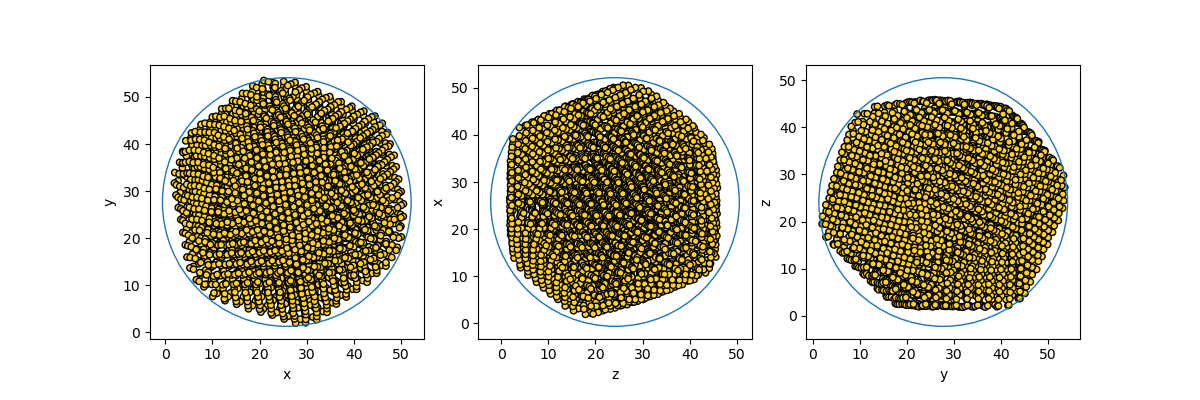

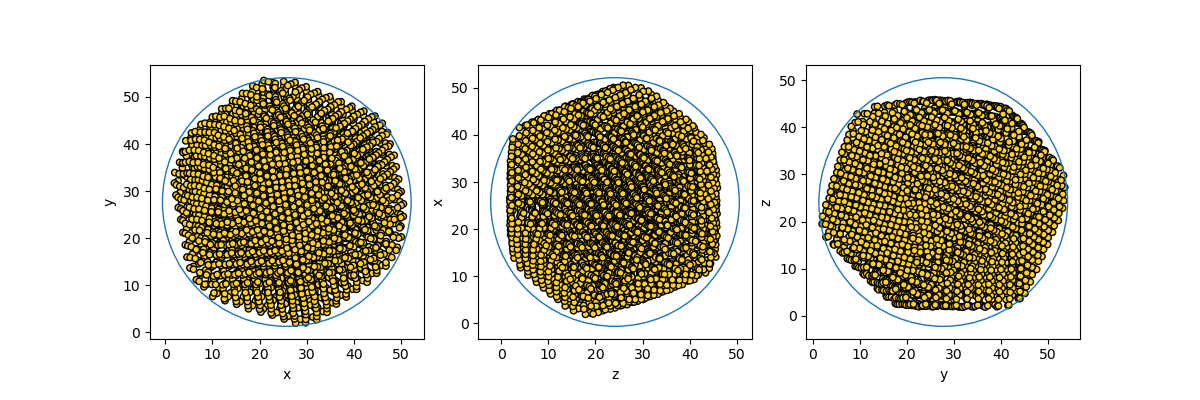

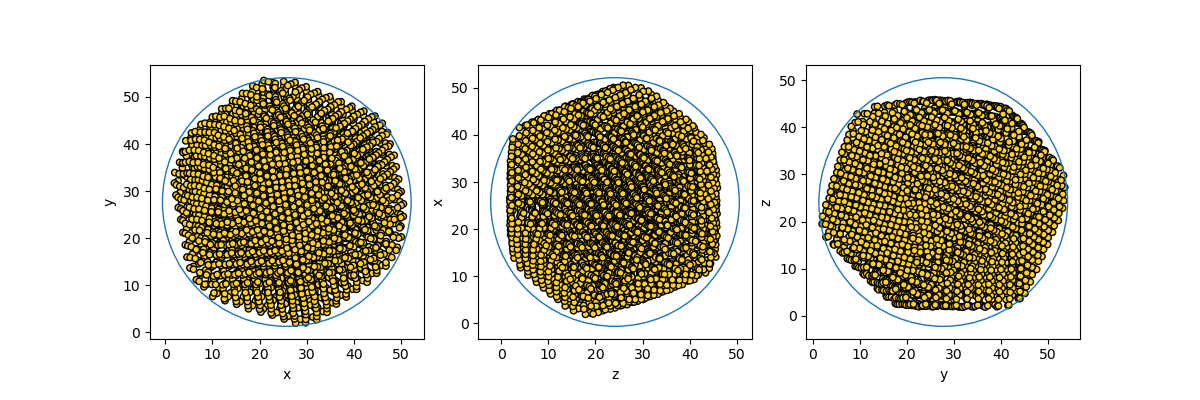

In [49]:
for obj in obj_list:
    display(obj)

### Surfactant measures

In [38]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'SurfactantMoleculeMeasures'}
}

In [39]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [40]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

.

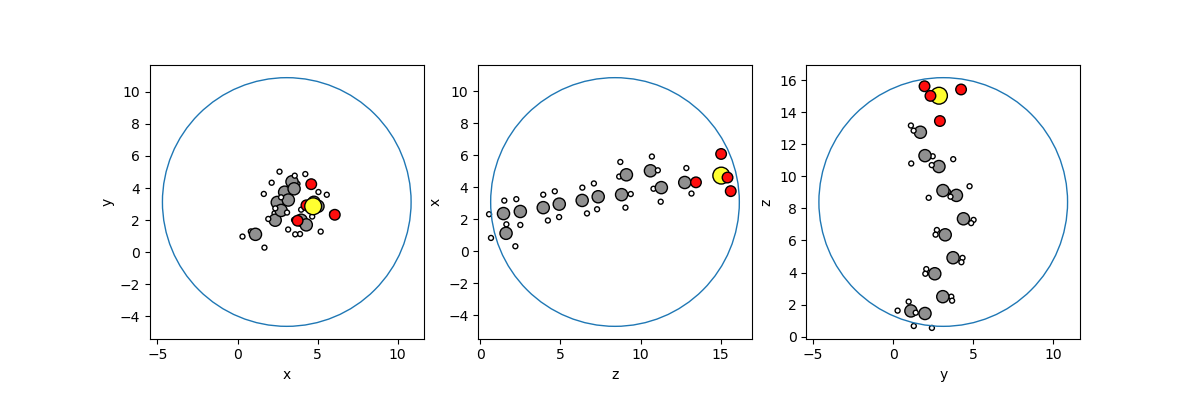

In [41]:
obj_list[0]

### Packing constraints

In [43]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'PackingConstraintSpheres'}
}

In [44]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [45]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

.

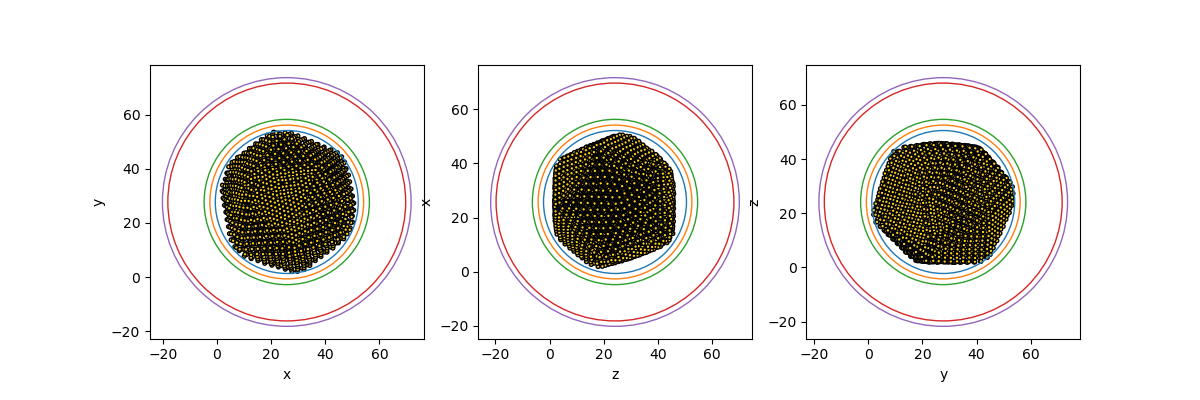

In [46]:
obj_list[0]

### Packed film

In [50]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'SphericalSurfactantPacking'}
}

In [51]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

3

In [52]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

...

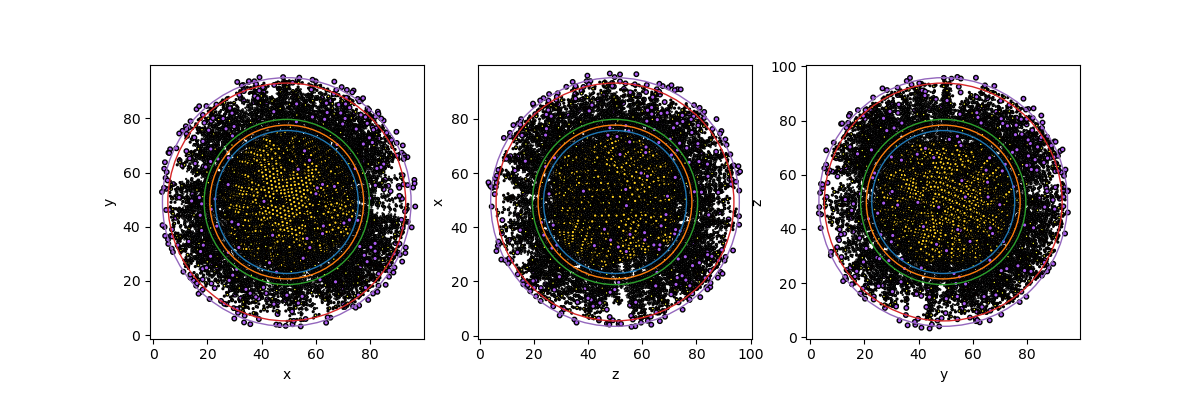

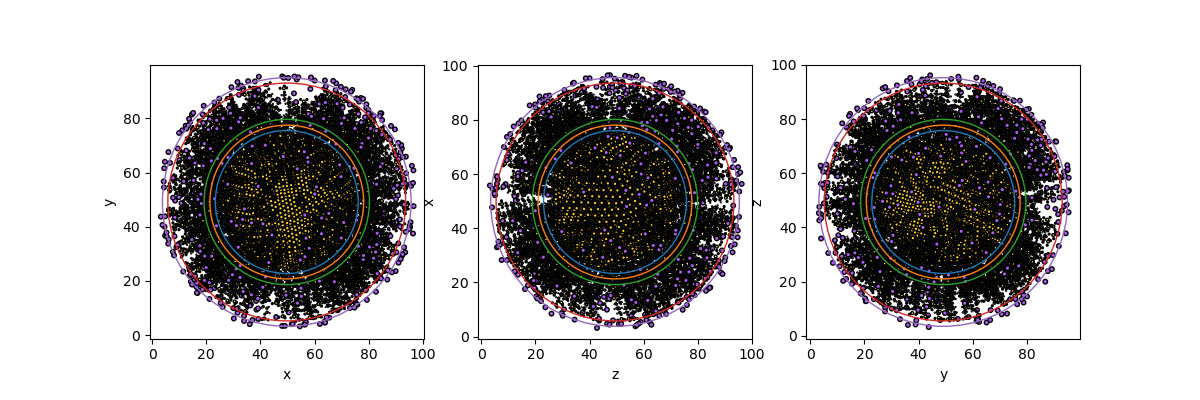

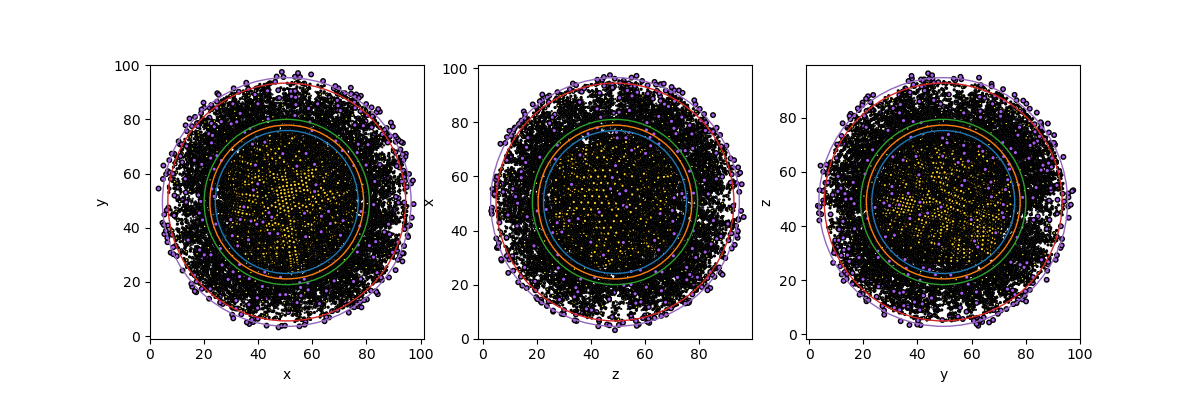

In [53]:
for obj in obj_list:
    display(obj)

## Energy minimization analysis

### Overview on objects in step

In [54]:
project_id = '2020-05-08-final'

In [55]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad'
}

In [56]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

57

In [57]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [58]:
res_df

type  name                    earliest  \
0                              mp4_file   NaN  2020-05-08 17:40:43.276711   
1                  surfactant_tail_rmsd   NaN  2020-05-08 17:40:43.276708   
2                  surfactant_head_rmsd   NaN  2020-05-08 17:40:43.276705   
3                        substrate_rmsd   NaN  2020-05-08 17:40:43.276703   
4                       counterion_rmsd   NaN  2020-05-08 17:40:43.276700   
5   surfactant_tail_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.276698   
6   surfactant_head_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.276695   
7   surfactant_head_surfactant_head_rdf   NaN  2020-05-08 17:40:43.276692   
8         substrate_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.276690   
9         substrate_surfactant_head_rdf   NaN  2020-05-08 17:40:43.276687   
10              substrate_substrate_rdf   NaN  2020-05-08 17:40:43.276684   
11       counterion_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.276682   
12       counterion_surfactant_head_rdf   NaN  2020-05-08 17:40:43.276679   
13             counterion_substrate_rdf   NaN  2020-05-08 17:40:43.276677   
14            counterion_counterion_rdf   NaN  2020-05-08 17:40:43.276674   
15                            data_file   NaN  2020-05-08 17:40:43.276671   
16                      trajectory_file   NaN  2020-05-08 17:40:43.276668   
17                          energy_file   NaN  2020-05-08 17:40:43.276665   
18                             log_file   NaN  2020-05-08 17:40:43.276660   

                        latest  object_count  
0   2020-05-08 20:09:19.734068             3  
1   2020-05-08 20:09:19.734065             3  
2   2020-05-08 20:09:19.734061             3  
3   2020-05-08 20:09:19.734058             3  
4   2020-05-08 20:09:19.734055             3  
5   2020-05-08 20:09:19.734052             3  
6   2020-05-08 20:09:19.734049             3  
7   2020-05-08 20:09:19.734046             3  
8   2020-05-08 20:09:19.734043             3  
9   2020-05-08 20:09:19.734040             3  
10  2020-05-08 20:09:19.734037             3  
11  2020-05-08 20:09:19.734034             3  
12  2020-05-08 20:09:19.734031             3  
13  2020-05-08 20:09:19.734028             3  
14  2020-05-08 20:09:19.734025             3  
15  2020-05-08 20:09:19.734022             3  
16  2020-05-08 20:09:19.734019             3  
17  2020-05-08 20:09:19.734016             3  
18  2020-05-08 20:09:19.734009             3

### Global observables

In [59]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad',  #{'$regex': 'GromacsEnergyMinimization'}
    "metadata.type": 'energy_file',
}
fp.filepad.count_documents(query)

3

In [60]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [61]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [62]:
[ c for c in cursor]

[{'_id': {'nmolecules': 481},
  'degeneracy': 1,
  'latest': '5eb585dcc35b0391733090ae'},
 {'_id': {'nmolecules': 438},
  'degeneracy': 1,
  'latest': '5eb5a8c2c35b03917330b261'},
 {'_id': {'nmolecules': 394},
  'degeneracy': 1,
  'latest': '5eb5aa14c35b03917330b370'}]

In [74]:
res_mi_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        em_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),em_df.index],
            names=[*c["_id"].keys(),'step'])
        em_mi_df = em_df.set_index(mi)        
        res_mi_list.append(em_mi_df)
    print('.',end='')
print('')

res_mi_df = pd.concat(res_mi_list)
res_df = res_mi_df.reset_index()

...


In [75]:
res_mi_df

Time           Bond            U-B   Proper Dih.  \
nmolecules step                                                           
481        0.0          0.0  195084.859375  114831.601562  17829.074219   
           1.0          1.0  194575.593750  114759.781250  17829.154297   
           2.0          2.0  193960.843750  114673.070312  17829.250000   
           3.0          3.0  193218.125000  114568.343750  17829.367188   
           4.0          4.0  192319.609375  114441.726562  17829.521484   
...                     ...            ...            ...           ...   
394        9995.0    9995.0     592.708130   31005.048828  10762.618164   
           9996.0    9996.0     592.708862   31003.271484  10762.637695   
           9998.0    9998.0     591.780823   31004.171875  10762.647461   
           9999.0    9999.0     593.176331   31003.210938  10762.715820   
           10000.0  10000.0     591.999939   31004.515625  10762.728516   

                           LJ-14     Coulomb-14      LJ (SR)   Coulomb (SR)  \
nmolecules step                                                               
481        0.0      11046.546875  127820.281250 -596796.7500 -200533.843750   
           1.0      11040.885742  127816.945312 -596822.8125 -200548.953125   
           2.0      11034.042969  127812.875000 -596854.0625 -200567.250000   
           3.0      11025.759766  127807.984375 -596891.5625 -200589.390625   
           4.0      11015.716797  127802.062500 -596936.6875 -200616.265625   
...                          ...            ...          ...            ...   
394        9995.0    2463.011963  101315.523438 -593518.7500 -279593.312500   
           9996.0    2462.678711  101315.210938 -593518.5000 -279592.812500   
           9998.0    2462.868408  101315.343750 -593518.8125 -279593.562500   
           9999.0    2462.611084  101315.000000 -593518.8750 -279594.375000   
           10000.0   2462.888184  101315.203125 -593519.3125 -279595.375000   

                     Coul. recip.      Potential  ...  Pres-XY  Pres-XZ  \
nmolecules step                                   ...                     
481        0.0      196834.437500 -133883.781250  ...      0.0      0.0   
           1.0      196811.078125 -134538.296875  ...      0.0      0.0   
           2.0      196782.515625 -135328.750000  ...      0.0      0.0   
           3.0      196748.468750 -136282.906250  ...      0.0      0.0   
           4.0      196706.812500 -137437.500000  ...      0.0      0.0   
...                           ...            ...  ...      ...      ...   
394        9995.0    13456.714844 -713516.437500  ...      0.0      0.0   
           9996.0    13457.516602 -713517.312500  ...      0.0      0.0   
           9998.0    13456.683594 -713518.875000  ...      0.0      0.0   
           9999.0    13456.418945 -713520.062500  ...      0.0      0.0   
           10000.0   13455.234375 -713522.062500  ...      0.0      0.0   

                    Pres-YX  Pres-YY  Pres-YZ  Pres-ZX  Pres-ZY  Pres-ZZ  \
nmolecules step                                                            
481        0.0          0.0      0.0      0.0      0.0      0.0      0.0   
           1.0          0.0      0.0      0.0      0.0      0.0      0.0   
           2.0          0.0      0.0      0.0      0.0      0.0      0.0   
           3.0          0.0      0.0      0.0      0.0      0.0      0.0   
           4.0          0.0      0.0      0.0      0.0      0.0      0.0   
...                     ...      ...      ...      ...      ...      ...   
394        9995.0       0.0      0.0      0.0      0.0      0.0      0.0   
           9996.0       0.0      0.0      0.0      0.0      0.0      0.0   
           9998.0       0.0      0.0      0.0      0.0      0.0      0.0   
           9999.0       0.0      0.0      0.0      0.0      0.0      0.0   
           10000.0      0.0      0.0      0.0      0.0      0.0      0.0   

                    #Surf*SurfTen  T-rest  
nmolecules

In [76]:
res_df

nmolecules     step     Time           Bond            U-B  \
0             481      0.0      0.0  195084.859375  114831.601562   
1             481      1.0      1.0  194575.593750  114759.781250   
2             481      2.0      2.0  193960.843750  114673.070312   
3             481      3.0      3.0  193218.125000  114568.343750   
4             481      4.0      4.0  192319.609375  114441.726562   
...           ...      ...      ...            ...            ...   
23760         394   9995.0   9995.0     592.708130   31005.048828   
23761         394   9996.0   9996.0     592.708862   31003.271484   
23762         394   9998.0   9998.0     591.780823   31004.171875   
23763         394   9999.0   9999.0     593.176331   31003.210938   
23764         394  10000.0  10000.0     591.999939   31004.515625   

        Proper Dih.         LJ-14     Coulomb-14      LJ (SR)   Coulomb (SR)  \
0      17829.074219  11046.546875  127820.281250 -596796.7500 -200533.843750   
1      17829.154297  11040.885742  127816.945312 -596822.8125 -200548.953125   
2      17829.250000  11034.042969  127812.875000 -596854.0625 -200567.250000   
3      17829.367188  11025.759766  127807.984375 -596891.5625 -200589.390625   
4      17829.521484  11015.716797  127802.062500 -596936.6875 -200616.265625   
...             ...           ...            ...          ...            ...   
23760  10762.618164   2463.011963  101315.523438 -593518.7500 -279593.312500   
23761  10762.637695   2462.678711  101315.210938 -593518.5000 -279592.812500   
23762  10762.647461   2462.868408  101315.343750 -593518.8125 -279593.562500   
23763  10762.715820   2462.611084  101315.000000 -593518.8750 -279594.375000   
23764  10762.728516   2462.888184  101315.203125 -593519.3125 -279595.375000   

       ...  Pres-XY  Pres-XZ  Pres-YX  Pres-YY  Pres-YZ  Pres-ZX  Pres-ZY  \
0      ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...    ...      ...      ...      ...      ...      ...      ...      ...   
23760  ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
23761  ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
23762  ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
23763  ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
23764  ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

       Pres-ZZ  #Surf*SurfTen  T-rest  
0          0.0            0.0     0.0  
1          0.0            0.0     0.0  
2          0.0            0.0     0.0  
3          0.0            0.0     0.0  
4          0.0            0.0     0.0  
...        ...            ...     ...  
23760      0.0            0.0     0.0  
23761      0.0            0.0     0.0  
23762      0.0            0.0     0.0  
23763      0.0            0.0     0.0  
23764      0.0            0.0     0.0  

[23765 rows x 33 columns]

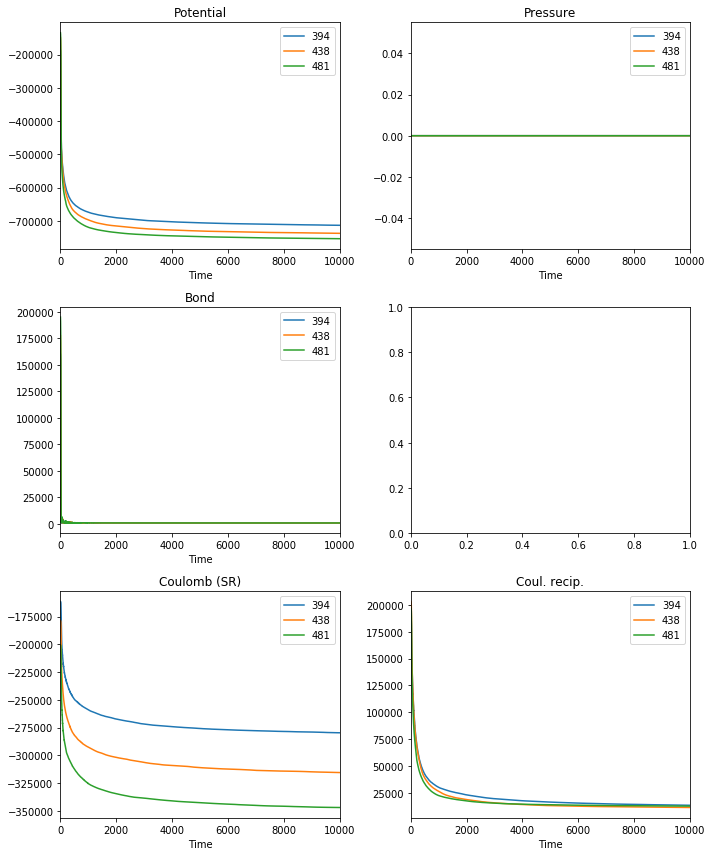

In [89]:
y_quantities = [
    'Potential',
    'Pressure',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

positions = [
    (0,0),
    (0,1),
    (1,0),
    (2,0),
    (2,1),
]
fig, ax = plt.subplots(3,2,figsize=(10,12))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Trajectory

In [83]:
query = { 
    "metadata.project": project_id,
    "metadata.step": 'GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad',
    "metadata.type":  { '$in': ['trajectory_file','data_file'] },
}
fp.filepad.count_documents(query)

2

In [84]:
# Building a rather sophisticated aggregation pipeline

# first group by nmolecules and type ...

parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules',
    'type': 'metadata.type'}
# parameter_names = ['nmolecules', 'type']

query = { 
    "metadata.project": project_id,
    "metadata.step": 'GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad',
    "metadata.type":  { '$in': ['trajectory_file','data_file'] },
}

aggregation_pipeline = []

aggregation_pipeline.append({ 
    "$match": query
})

aggregation_pipeline.append({ 
    "$sort": { 
        "metadata.system.surfactant.nmolecules": pymongo.ASCENDING,
        "metadata.datetime": pymongo.DESCENDING,
    }
})

aggregation_pipeline.append({ 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
})

# second group by nmolecules

parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

aggregation_pipeline.append({ 
    "$group": { 
        "_id": { field: '$_id.{}'.format(field) for field in parameter_dict.keys() },
        "type":     {"$addToSet": "$_id.type"},
        "gfs_id":   {"$addToSet": "$latest"} 
        #"$_id.type": "$latest"
    }
})

aggregation_pipeline.append({
    '$project': {
         '_id': False,
        **{field: '$_id.{}'.format(field) for field in parameter_dict.keys()},
        'objects': { 
            '$zip': {
                'inputs': [ '$type', '$gfs_id' ],
                'useLongestLength': True,
                'defaults':  [None,None]
            }
        }
    }
})

aggregation_pipeline.append({ 
    '$project': {
        **{p: True for p in parameter_dict.keys()},
        'objects': {'$arrayToObject': '$objects'}
        #'objects': False 
    }
})

aggregation_pipeline.append({ 
    '$addFields': {
        'objects': {**{ field: '${}'.format(field) for field in parameter_dict.keys()}}
    }
})

aggregation_pipeline.append({ 
    '$replaceRoot': { 'newRoot': '$objects' }
})

# display results with
# for i, c in enumerate(cursor): 
#    print(c)
# yields documents in the form
# {'em_gro': '5e6a4e3d6c26f976ceae5e38', 'em_trr': '5e6a4e3a6c26f976ceae5e14', 'nmolecules': '44'}
# i.e. most recent topology file and trajectory file per concentration

cursor = fp.filepad.aggregate(aggregation_pipeline)

mda_trr_list = []
for i, c in enumerate(cursor): 
    em_gro_content, _ = fp.get_file_by_id(c["data_file"])
    em_trr_content, _ = fp.get_file_by_id(c["trajectory_file"])
    # Stream approach won't work
    # with io.TextIOWrapper( io.BytesIO(em_gro_content) ) as gro, \
    #    io.BytesIO(em_trr_content) as trr:   
        #mda_trr_list.append( 
        #    mda.Universe( 
        #        gro,trr, topology_format = 'GRO', format='TRR') )
    with tempfile.NamedTemporaryFile(suffix='.gro') as gro, \
        tempfile.NamedTemporaryFile(suffix='.trr') as trr:
        gro.write(em_gro_content)
        trr.write(em_trr_content)
        mda_trr_list.append( mda.Universe(gro.name,trr.name) )
    print('.',end='')
print('')
del em_gro_content
del em_trr_content

.


/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [85]:
mda_trr = mda_trr_list[0]

mda_view = nglview.show_mdanalysis(mda_trr)

mda_view.clear_representations()
mda_view.background = 'white'
mda_view.add_representation('ball+stick')
mda_view

/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


NGLWidget(max_frame=79)

###  Rendered videos

In [86]:
project_id = '2020-05-08-final'

In [89]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [90]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [91]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [92]:
res_df

step      type  name  \
0  GromacsEnergyMinimization:ProcessAnalyzeAndVis...  mp4_file   NaN   

                     earliest                      latest  object_count  
0  2020-05-08 17:40:43.276711  2020-05-08 17:40:43.276711             1

In [103]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        obj_list.append(Video.from_file(tmp.name))
    print('.',end='')

.

In [105]:
obj_list[0]

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0cm!mdat\x00\x00\…

## Pulling analysis

### Overview on objects in step

In [94]:
project_id = '2020-05-08-final'

In [95]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsPull:ProcessAnalyzeAndVisualize:push_filepad'
}

In [96]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

46

In [97]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [98]:
res_df

type  name                    earliest  \
0                              mp4_file   NaN  2020-05-08 17:40:43.287032   
1                  surfactant_tail_rmsd   NaN  2020-05-08 17:40:43.287029   
2                  surfactant_head_rmsd   NaN  2020-05-08 17:40:43.287027   
3                        substrate_rmsd   NaN  2020-05-08 17:40:43.287024   
4                       counterion_rmsd   NaN  2020-05-08 17:40:43.287021   
5   surfactant_tail_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.287019   
6   surfactant_head_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.287016   
7   surfactant_head_surfactant_head_rdf   NaN  2020-05-08 17:40:43.287013   
8         substrate_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.287011   
9         substrate_surfactant_head_rdf   NaN  2020-05-08 17:40:43.287008   
10              substrate_substrate_rdf   NaN  2020-05-08 17:40:43.287005   
11       counterion_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.287003   
12       counterion_surfactant_head_rdf   NaN  2020-05-08 17:40:43.287000   
13             counterion_substrate_rdf   NaN  2020-05-08 17:40:43.286997   
14            counterion_counterion_rdf   NaN  2020-05-08 17:40:43.286995   
15                        topology_file   NaN  2020-05-08 17:40:43.286992   
16                           pullx_file   NaN  2020-05-08 17:40:43.286990   
17                           pullf_file   NaN  2020-05-08 17:40:43.286987   
18                            data_file   NaN  2020-05-08 17:40:43.286984   
19           compressed_trajectory_file   NaN  2020-05-08 17:40:43.286982   
20                      trajectory_file   NaN  2020-05-08 17:40:43.286979   
21                          energy_file   NaN  2020-05-08 17:40:43.286976   
22                             log_file   NaN  2020-05-08 17:40:43.286971   

                        latest  object_count  
0   2020-05-08 20:09:19.747773             2  
1   2020-05-08 20:09:19.747770             2  
2   2020-05-08 20:09:19.747768             2  
3   2020-05-08 20:09:19.747765             2  
4   2020-05-08 20:09:19.747762             2  
5   2020-05-08 20:09:19.747759             2  
6   2020-05-08 20:09:19.747755             2  
7   2020-05-08 20:09:19.747752             2  
8   2020-05-08 20:09:19.747745             2  
9   2020-05-08 20:09:19.747742             2  
10  2020-05-08 20:09:19.747739             2  
11  2020-05-08 20:09:19.747736             2  
12  2020-05-08 20:09:19.747733             2  
13  2020-05-08 20:09:19.747730             2  
14  2020-05-08 20:09:19.747727             2  
15  2020-05-08 20:09:19.747724             2  
16  2020-05-08 20:09:19.747721             2  
17  2020-05-08 20:09:19.747718             2  
18  2020-05-08 20:09:19.747715             2  
19  2020-05-08 20:09:19.747712             2  
20  2020-05-08 20:09:19.747708             2  
21  2020-05-08 20:09:19.747705             2  
22  2020-05-08 20:09:19.747699             2

### Global observables

The `gmx energy` table:

```
  1  Restraint-Pot.   2  U-B              3  Proper-Dih.      4  LJ-14         
  5  Coulomb-14       6  LJ-(SR)          7  Coulomb-(SR)     8  Coul.-recip.  
  9  Position-Rest.  10  COM-Pull-En.    11  Potential       12  Kinetic-En.   
 13  Total-Energy    14  Temperature     15  Pressure        16  Constr.-rmsd  
 17  Vir-XX          18  Vir-XY          19  Vir-XZ          20  Vir-YX        
 21  Vir-YY          22  Vir-YZ          23  Vir-ZX          24  Vir-ZY        
 25  Vir-ZZ          26  Pres-XX         27  Pres-XY         28  Pres-XZ       
 29  Pres-YX         30  Pres-YY         31  Pres-YZ         32  Pres-ZX       
 33  Pres-ZY         34  Pres-ZZ         35  #Surf*SurfTen   36  T-rest       
 ```
 converted to dict with regex
 
     \s+([0-9]+)\s+([^\s]+)
 
 and replacement
 
     '$2': $1,\n

In [99]:
gmx_energy_dict = {
    'Restraint-Pot.': 1,
    'U-B': 2,
    'Proper-Dih.': 3,
    'LJ-14': 4,
    'Coulomb-14': 5,
    'LJ-(SR)': 6,
    'Coulomb-(SR)': 7,
    'Coul.-recip.': 8,
    'Position-Rest.': 9,
    'COM-Pull-En.': 10,
    'Potential': 11,
    'Kinetic-En.': 12,
    'Total-Energy': 13,
    'Temperature': 14,
    'Pressure': 15,
    'Constr.-rmsd': 16,
    'Vir-XX': 17,
    'Vir-XY': 18,
    'Vir-XZ': 19,
    'Vir-YX': 20,
    'Vir-YY': 21,
    'Vir-YZ': 22,
    'Vir-ZX': 23,
    'Vir-ZY': 24,
    'Vir-ZZ': 25,
    'Pres-XX': 26,
    'Pres-XY': 27,
    'Pres-XZ': 28,
    'Pres-YX': 29,
    'Pres-YY': 30,
    'Pres-YZ': 31,
    'Pres-ZX': 32,
    'Pres-ZY': 33,
    'Pres-ZZ': 34,
    '#Surf*SurfTen': 35,
    'T-rest': 36,
}

In [100]:
project_id = '2020-05-08-final'

In [101]:
query = { 
    "metadata.project": project_id,
    "metadata.type":    'energy_file',
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

2

In [102]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [103]:
gmx_energy_selection = [
    'Restraint-Pot.',
    'Position-Rest.',
    'COM-Pull-En.',
    'Potential',
    'Kinetic-En.',
    'Total-Energy',
    'Temperature',
    'Pressure',
    'Constr.-rmsd',
]

In [116]:
res_list = []
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

res_df_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    
    #df = panedr.edr_to_df(tmp.name), fails
    tmpin = tempfile.NamedTemporaryFile(mode='w+b',suffix='.edr', delete=False)
    
    # cur_res_dict = {}
    with tmpin:
        tmpin.write(content)
        #tmpin.seek(0)
       
    res_df = None
    for sel in gmx_energy_selection:  
        try:
            tmpout = tempfile.NamedTemporaryFile(suffix='.xvg', delete=False)
            res = gromacs.energy(f=tmpin.name,o=tmpout.name,
                                 input=str(gmx_energy_dict[sel]))
            #with open(tmpout.name,'r') as f:
            #    xvg = f.read()
            #tmpout.delete()
            xvg = mda.auxiliary.XVG.XVGReader(tmpout.name)
            xvg_time = xvg.read_all_times()
            xvg_data = np.array([ f.data[1:] for f in xvg ]).flatten() # 1st entry contains times
            os.unlink(tmpout.name)
        except: 
            logger.warning("Failed to read '{:s}' from data set {:d}.".format(sel,i))
            failed_list.append((nmolecules, sel))
        else:
            r = {'nmolecules': [nmolecules]*len(xvg_time), 'time': xvg_time, sel: xvg_data}
            cur_df = pd.DataFrame(r)
            if res_df is None:
                res_df = cur_df
            else:
                res_df = pd.merge(res_df, cur_df, how='outer', on=['nmolecules', 'time'])
    res_df_list.append(res_df)
    os.unlink(tmpin.name)
    print('.',end='')
print('')
res_df = pd.concat(res_df_list)
res_df_mi = res_df.set_index(['nmolecules','time'])

..


In [122]:
res_mi_df

Time           Bond            U-B   Proper Dih.  \
nmolecules step                                                           
481        0.0          0.0  195084.859375  114831.601562  17829.074219   
           1.0          1.0  194575.593750  114759.781250  17829.154297   
           2.0          2.0  193960.843750  114673.070312  17829.250000   
           3.0          3.0  193218.125000  114568.343750  17829.367188   
           4.0          4.0  192319.609375  114441.726562  17829.521484   
...                     ...            ...            ...           ...   
394        9995.0    9995.0     592.708130   31005.048828  10762.618164   
           9996.0    9996.0     592.708862   31003.271484  10762.637695   
           9998.0    9998.0     591.780823   31004.171875  10762.647461   
           9999.0    9999.0     593.176331   31003.210938  10762.715820   
           10000.0  10000.0     591.999939   31004.515625  10762.728516   

                           LJ-14     Coulomb-14      LJ (SR)   Coulomb (SR)  \
nmolecules step                                                               
481        0.0      11046.546875  127820.281250 -596796.7500 -200533.843750   
           1.0      11040.885742  127816.945312 -596822.8125 -200548.953125   
           2.0      11034.042969  127812.875000 -596854.0625 -200567.250000   
           3.0      11025.759766  127807.984375 -596891.5625 -200589.390625   
           4.0      11015.716797  127802.062500 -596936.6875 -200616.265625   
...                          ...            ...          ...            ...   
394        9995.0    2463.011963  101315.523438 -593518.7500 -279593.312500   
           9996.0    2462.678711  101315.210938 -593518.5000 -279592.812500   
           9998.0    2462.868408  101315.343750 -593518.8125 -279593.562500   
           9999.0    2462.611084  101315.000000 -593518.8750 -279594.375000   
           10000.0   2462.888184  101315.203125 -593519.3125 -279595.375000   

                     Coul. recip.      Potential  ...  Pres-XY  Pres-XZ  \
nmolecules step                                   ...                     
481        0.0      196834.437500 -133883.781250  ...      0.0      0.0   
           1.0      196811.078125 -134538.296875  ...      0.0      0.0   
           2.0      196782.515625 -135328.750000  ...      0.0      0.0   
           3.0      196748.468750 -136282.906250  ...      0.0      0.0   
           4.0      196706.812500 -137437.500000  ...      0.0      0.0   
...                           ...            ...  ...      ...      ...   
394        9995.0    13456.714844 -713516.437500  ...      0.0      0.0   
           9996.0    13457.516602 -713517.312500  ...      0.0      0.0   
           9998.0    13456.683594 -713518.875000  ...      0.0      0.0   
           9999.0    13456.418945 -713520.062500  ...      0.0      0.0   
           10000.0   13455.234375 -713522.062500  ...      0.0      0.0   

                    Pres-YX  Pres-YY  Pres-YZ  Pres-ZX  Pres-ZY  Pres-ZZ  \
nmolecules step                                                            
481        0.0          0.0      0.0      0.0      0.0      0.0      0.0   
           1.0          0.0      0.0      0.0      0.0      0.0      0.0   
           2.0          0.0      0.0      0.0      0.0      0.0      0.0   
           3.0          0.0      0.0      0.0      0.0      0.0      0.0   
           4.0          0.0      0.0      0.0      0.0      0.0      0.0   
...                     ...      ...      ...      ...      ...      ...   
394        9995.0       0.0      0.0      0.0      0.0      0.0      0.0   
           9996.0       0.0      0.0      0.0      0.0      0.0      0.0   
           9998.0       0.0      0.0      0.0      0.0      0.0      0.0   
           9999.0       0.0      0.0      0.0      0.0      0.0      0.0   
           10000.0      0.0      0.0      0.0      0.0      0.0      0.0   

                    #Surf*SurfTen  T-rest  
nmolecules

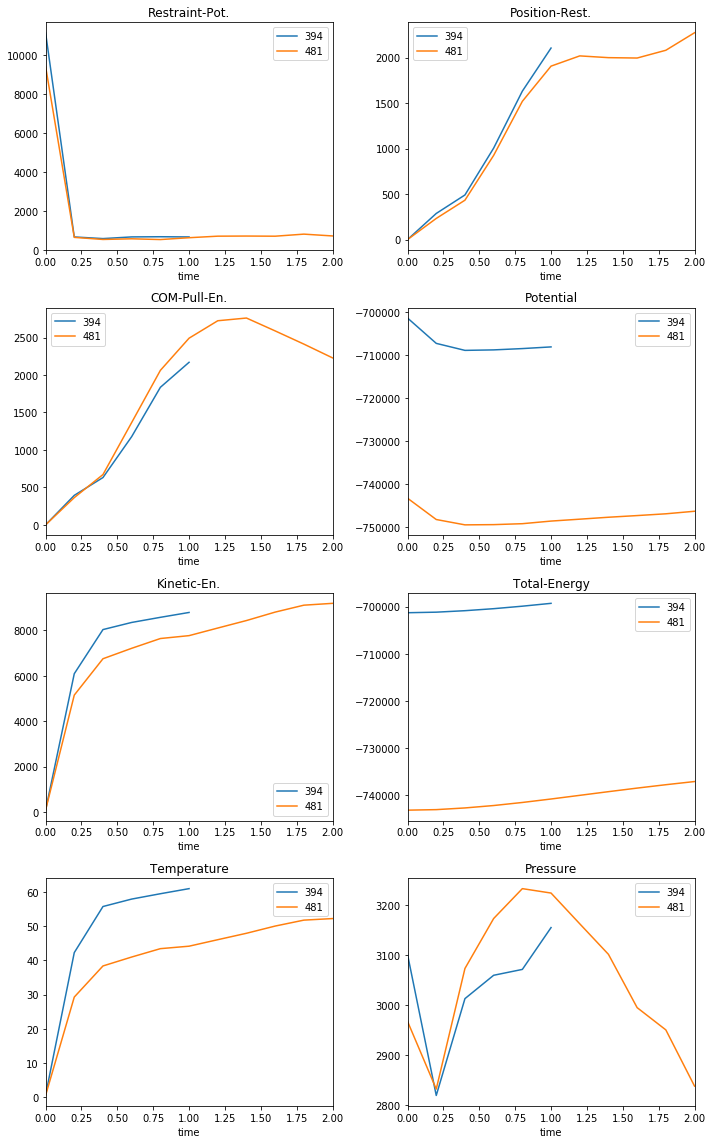

In [121]:
cols = 2
y_quantities = [
    'Restraint-Pot.',
    'Position-Rest.',
    'COM-Pull-En.',
    'Potential',
    'Kinetic-En.',
    'Total-Energy',
    'Temperature',
    'Pressure',
    'Constr.-rmsd',
    ]
n = len(y_quantities)
rows = round(n/cols)
positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Pulling forces

In [130]:
res_df_list = []
failed_list = []

query = { 
    "metadata.project": project_id,
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
    "metadata.type": 'pullf_file',
}

fp.filepad.count_documents(query)
match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    
    tmpin = tempfile.NamedTemporaryFile(mode='w+b',suffix='.xvg', delete=False)
    
    with tmpin:
        tmpin.write(content)
        
    try:
        xvg = mda.auxiliary.XVG.XVGReader(tmpin.name)
        xvg_time = xvg.read_all_times()
        xvg_data = np.array([ f.data[1:] for f in xvg ])# .flatten() # 1st entry contains times
    except: 
        logger.warning("Failed to read data set {:d}.".format(i))
        failed_list.append(nmolecules)
    else:
        res_df_list.append(pd.DataFrame({
            'nmolecules': np.array([nmolecules]*len(xvg_time), dtype=int),
            'time': xvg_time, 
            **{i: xvg_data[:,i] for i in range(nmolecules)}
        }))
    os.unlink(tmpin.name)
    print('.',end='')
print('')
res_df = pd.concat(res_df_list)
res_df_mi = res_df.set_index(['nmolecules','time'])

..


/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:65: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



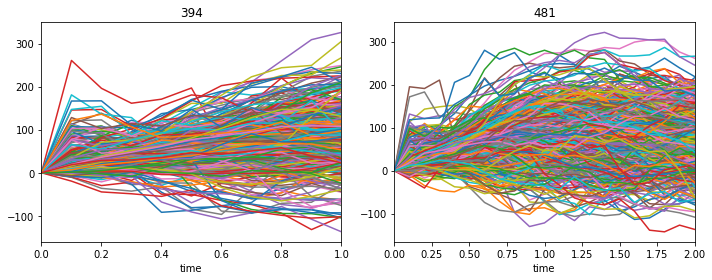

In [166]:
n = len(res_df['nmolecules'].unique())
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for pos, (key, grp) in zip(positions,res_df.groupby(['nmolecules'])):
    columns = list(set(grp.columns) - set(['nmolecules','time']))
    grp.plot('time', columns, ax=ax[pos],title=key,legend=None)
fig.tight_layout()

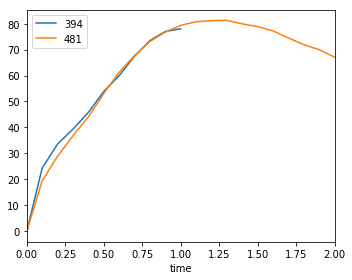

In [176]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
for key, grp in res_df.groupby(['nmolecules']):
    columns = list(set(grp.columns) - set(['nmolecules','time']))
    grp = grp.set_index('time')
    grp = grp.drop(columns='nmolecules')
    grp.mean(axis=1).plot(legend=True, label=key, ax=ax)
fig.tight_layout()
#fig.legend()

### Pulling groups movement

In [200]:
res_df_list = []
failed_list = []

query = { 
    "metadata.project": project_id,
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
    "metadata.type":    'pullx_file',
}

fp.filepad.count_documents(query)
match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)


for i, c in enumerate(cursor): 
    print(c["_id"])
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])  # int(metadata["metadata"]["nmolecules"])
    
    tmpin = tempfile.NamedTemporaryFile(mode='w+b',suffix='.xvg', delete=False)
    
    with tmpin:
        tmpin.write(content)
        
    try:
        xvg = gromacs.fileformats.XVG(tmpin.name)
        xvg_time = xvg.array[0,:]
        
        #xvg_labels = ['1', '1 ref', '1 dX', '1 dY', '1 dZ', '1 g 1 X', '1 g 1 Y', '1 g 1 Z', '1 g 2 X', '1 g 2 Y', '1 g 2 Z']
        N_pull_coords = nmolecules
        N_cols = len(xvg.names)
        N_cols_per_coord = int(N_cols / N_pull_coords)
        
        xvg_labels = xvg.names[:N_cols_per_coord]
        xvg_data = {}
        for j in range(N_pull_coords):
            for k in range(N_cols_per_coord):
                xvg_data[(j,xvg_labels[k])] = xvg.array[
                    1+j*N_cols_per_coord+k,:]
        
    except: 
        logger.exception("Failed to read data set {:d}.".format(i))
        failed_list.append(nmolecules)

    else:
        # res_list.append({
        #    'nmolecules': nmolecules, # np.array([nmolecules]*len(xvg_time), dtype=int),
        #    'time': xvg_time, 
        #    **xvg_data})
        res_df_list.append(pd.DataFrame({
            'nmolecules': np.array([nmolecules]*len(xvg_time), dtype=int),
            'time': xvg_time, 
            **xvg_data # {i: xvg_data[:,i] for i in range(nmolecules)}
        }))
    #os.unlink(tmpin.name)
    #print('.',end='')
#print('')
res_df = pd.concat(res_df_list)
res_df_mi = res_df.set_index(['nmolecules','time'])
res_df_mi.columns = pd.MultiIndex.from_tuples(res_df_mi.columns, names=['nmolecule', 'coord'])

{'nmolecules': 481}
{'nmolecules': 394}


/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [201]:
res_df_mi

nmolecule            0                                                  \
coord                  1    1 ref     1 dX      1 dY      1 dZ 1 g 1 X   
nmolecules time                                                          
481        0.0   3.02906  3.02901  2.66919  0.972790 -1.050880   6.799   
           0.2   3.03794  3.04901  2.67309  0.983250 -1.056830   6.799   
           0.4   3.05326  3.06901  2.68071  1.007890 -1.058480   6.799   
           0.6   3.06563  3.08901  2.69744  1.008480 -1.051100   6.799   
           0.8   3.09596  3.10901  2.74954  0.999092 -1.013290   6.799   
           1.0   3.14800  3.12901  2.83244  0.995250 -0.946942   6.799   
           1.2   3.17439  3.14901  2.86186  0.994418 -0.947435   6.799   
           1.4   3.18378  3.16901  2.88309  0.990935 -0.917793   6.799   
           1.6   3.21366  3.18901  2.90658  0.992222 -0.945999   6.799   
           1.8   3.17210  3.20901  2.87922  0.932685 -0.949957   6.799   
           2.0   3.17984  3.22901  2.91260  0.907658 -0.896820   6.799   
394        0.0   3.05858  3.05857  1.78935  2.047640  1.400090   6.749   
           0.2   3.05403  3.07857  1.78596  2.048270  1.393570   6.749   
           0.4   3.05479  3.09857  1.78296  2.062130  1.378560   6.749   
           0.6   3.05652  3.11857  1.78044  2.082220  1.355260   6.749   
           0.8   3.06050  3.13857  1.79027  2.090670  1.338160   6.749   
           1.0   3.04806  3.15857  1.75489  2.082030  1.369750   6.749   

nmolecule                                          ...      480           \
coord           1 g 1 Y 1 g 1 Z  1 g 2 X  1 g 2 Y  ...    1 ref     1 dX   
nmolecules time                                    ...                     
481        0.0    6.864   6.719  9.46819  7.83679  ...  3.01831  2.38696   
           0.2    6.864   6.719  9.47209  7.84725  ...  3.03831  2.27977   
           0.4    6.864   6.719  9.47971  7.87189  ...  3.05831  2.28257   
           0.6    6.864   6.719  9.49645  7.87248  ...  3.07831  2.28185   
           0.8    6.864   6.719  9.54855  7.86309  ...  3.09831  2.32824   
           1.0    6.864   6.719  9.63144  7.85925  ...  3.11831  2.30186   
           1.2    6.864   6.719  9.66086  7.85841  ...  3.13831  2.30604   
           1.4    6.864   6.719  9.68209  7.85493  ...  3.15831  2.28607   
           1.6    6.864   6.719  9.70558  7.85622  ...  3.17831  2.32212   
           1.8    6.864   6.719  9.67822  7.79668  ...  3.19831  2.32306   
           2.0    6.864   6.719  9.71161  7.77165  ...  3.21831  2.25383   
394        0.0    6.708   6.695  8.53836  8.75564  ...      NaN      NaN   
           0.2    6.708   6.695  8.53496  8.75627  ...      NaN      NaN   
           0.4    6.708   6.695  8.53196  8.77013  ...      NaN      NaN   
           0.6    6.708   6.695  8.52944  8.79022  ...      NaN      NaN   
           0.8    6.708   6.695  8.53927  8.79867  ...      NaN      NaN   
           1.0    6.708   6.695  8.50389  8.79003  ...      NaN      NaN   

nmolecule                                                                     \
coord                1 dY     1 dZ 1 g 1 X 1 g 1 Y 1 g 1 Z  1 g 2 X  1 g 2 Y   
nmolecules time                                                                
481        0.0   0.494021  1.78012   6.799   6.864   6.719  9.18597  7.35802   
           0.2   0.544691  1.73617   6.799   6.864   6.719  9.07878  7.40869   
           0.4   0.558456  1.70655   6.799   6.864   6.719  9.08157  7.42245   
           0.6   0.497096  1.65842   6.799   6.864   6.719  9.08085  7.36109   
           0.8   0.429504  1.70809   6.799   6.864   6.719  9.12725  7.29350   
           1.0   0.364192  1.71248   6.799   6.864   6.719  9.10086  7.22819   
           1.2   0.322844  1.74924   6.799   6.864   6.719  9.10505  7.18684   
           1.4   0.316541  1.78839   6.799   6.864   6.719  9.08507  7.18054   
           1.6   0.339476  1.81602   6.799   6.864   6.719  9.12112  7.20347   
           1.8   0.381216  1.88068   6

In [205]:
res_df = res_df_mi.groupby(axis=1,level='coord').mean().reset_index()

In [206]:
res_df

coord  nmolecules  time         1      1 dX      1 dY      1 dZ  1 g 1 X  \
0             481   0.0  3.034603 -0.014782 -0.072324  0.067737    6.799   
1             481   0.2  3.025667 -0.013379 -0.071653  0.067348    6.799   
2             481   0.4  3.030492 -0.012010 -0.072757  0.068189    6.799   
3             481   0.6  3.033248 -0.012250 -0.071917  0.069837    6.799   
4             481   0.8  3.041405 -0.010377 -0.070809  0.071367    6.799   
5             481   1.0  3.055184 -0.011973 -0.068760  0.070676    6.799   
6             481   1.2  3.073354 -0.012317 -0.064740  0.070296    6.799   
7             481   1.4  3.094607 -0.014176 -0.062981  0.068756    6.799   
8             481   1.6  3.117301 -0.015379 -0.062236  0.065859    6.799   
9             481   1.8  3.142625 -0.015499 -0.061888  0.062633    6.799   
10            481   2.0  3.167460 -0.017566 -0.061462  0.060240    6.799   
11            394   0.0  3.039270  0.042538  0.071386  0.102983    6.749   
12            394   0.2  3.025625  0.040786  0.071826  0.102654    6.749   
13            394   0.4  3.033426  0.041019  0.071801  0.100607    6.749   
14            394   0.6  3.039252  0.039253  0.066570  0.102179    6.749   
15            394   0.8  3.045733  0.038341  0.059687  0.103985    6.749   
16            394   1.0  3.061185  0.034311  0.054671  0.105422    6.749   

coord  1 g 1 Y  1 g 1 Z   1 g 2 X   1 g 2 Y   1 g 2 Z     1 ref  
0        6.864    6.719  6.784223  6.791673  6.786737  3.034543  
1        6.864    6.719  6.785625  6.792343  6.786349  3.054543  
2        6.864    6.719  6.786995  6.791240  6.787190  3.074543  
3        6.864    6.719  6.786754  6.792080  6.788838  3.094543  
4        6.864    6.719  6.788628  6.793188  6.790368  3.114543  
5        6.864    6.719  6.787031  6.795238  6.789677  3.134543  
6        6.864    6.719  6.786687  6.799257  6.789297  3.154543  
7        6.864    6.719  6.784828  6.801015  6.787757  3.174543  
8        6.864    6.719  6.783625  6.801761  6.784861  3.194543  
9        6.864    6.719  6.783506  6.802109  6.781634  3.214543  
10       6.864    6.719  6.781438  6.802535  6.779241  3.234543  
11       6.708    6.695  6.791542  6.779382  6.797985  3.039219  
12       6.708    6.695  6.789791  6.779823  6.797655  3.059219  
13       6.708    6.695  6.790023  6.779798  6.795608  3.079219  
14       6.708    6.695  6.788257  6.774567  6.797180  3.099219  
15       6.708    6.695  6.787346  6.767683  6.798986  3.119219  
16       6.708    6.695  6.783316  6.762668  6.800423  3.139219

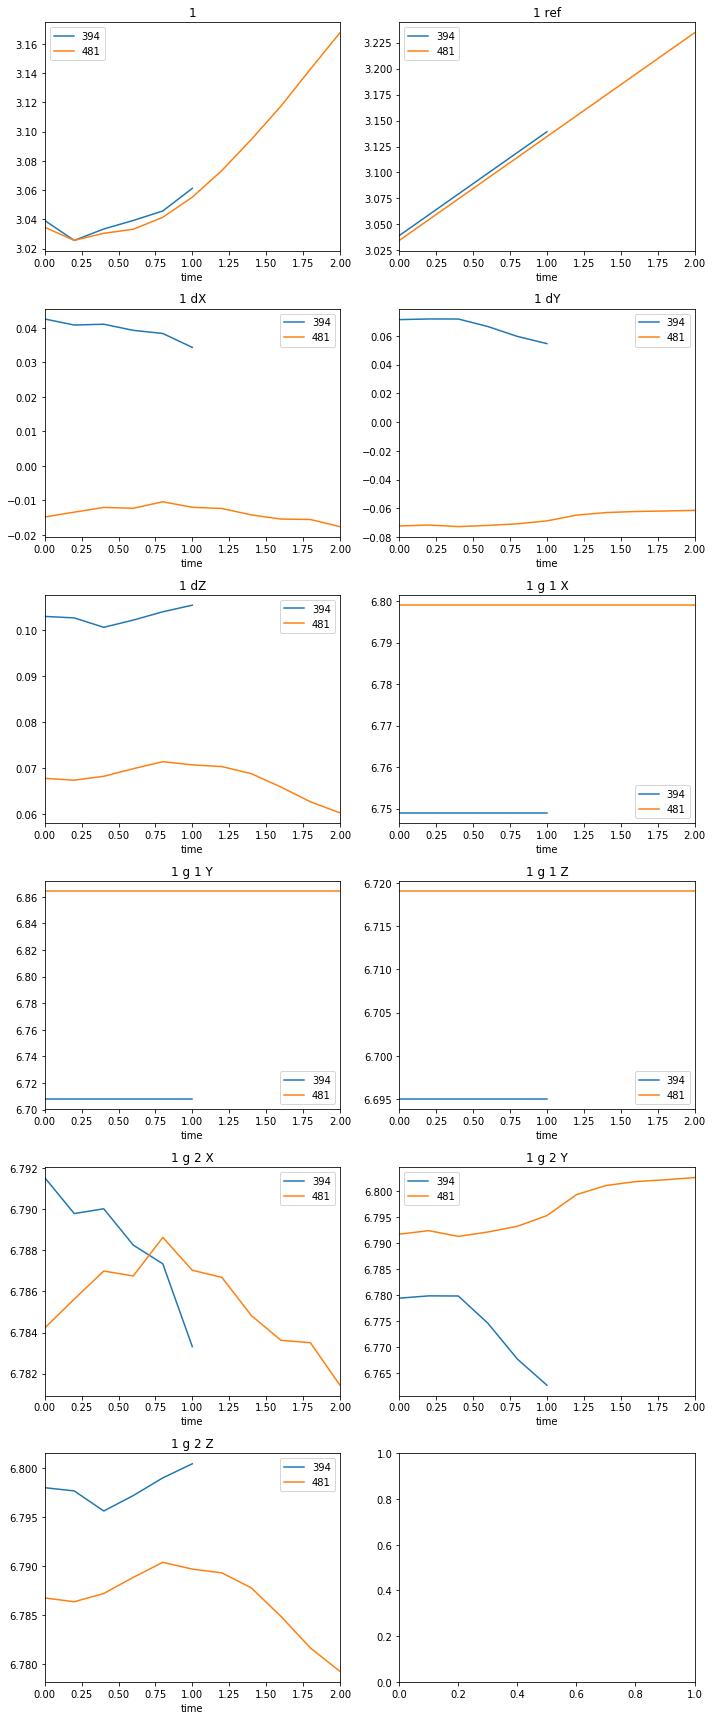

In [207]:
cols = 2
y_quantities = [
    '1', 
    '1 ref', 
    '1 dX', 
    '1 dY', 
    '1 dZ', 
    '1 g 1 X', 
    '1 g 1 Y', 
    '1 g 1 Z', 
    '1 g 2 X', 
    '1 g 2 Y', 
    '1 g 2 Z'
]
n = len(y_quantities)
rows = round(n/cols)
positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [138]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules',
    'type': 'metadata.type'}

query = { 
    "metadata.project": project_id,
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
    "metadata.type": { '$in': ['trajectory_file','data_file'] },
}

aggregation_pipeline = []

aggregation_pipeline.append({ 
    "$match": query
})



aggregation_pipeline.append({ 
    "$sort": { 
        "metadata.system.surfactant.nmolecules": pymongo.ASCENDING,
        "metadata.datetime": pymongo.DESCENDING,
    }
})

aggregation_pipeline.append({ 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
})

parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

aggregation_pipeline.append({ 
    "$group": { 
        "_id": { p: '$_id.{}'.format(p) for p in parameter_dict.keys() },
        "type":     {"$addToSet": "$_id.type"},
        "gfs_id":   {"$addToSet": "$latest"} 
        #"$_id.type": "$latest"
    }
})

aggregation_pipeline.append({
    '$project': {
         '_id': False,
        **{ p: '$_id.{}'.format(p) for p in parameter_dict.keys()},
        'objects': { 
            '$zip': {
                'inputs': [ '$type', '$gfs_id' ],
                'useLongestLength': True,
                'defaults':  [None,None]
            }
        }
    }
})

aggregation_pipeline.append({ 
    '$project': {
        **{ p: True for p in parameter_dict.keys()},
        'objects': {'$arrayToObject': '$objects'}
        #'objects': False 
    }
})

aggregation_pipeline.append({ 
    '$addFields': {
        'objects': {**{ p: '${}'.format(p) for p in parameter_dict.keys()}}
    }
})

aggregation_pipeline.append({ 
    '$replaceRoot': { 'newRoot': '$objects' }
})

# display results with
# for i, c in enumerate(cursor): 
#    print(c)
# yields documents in the form
# {'em_gro': '5e6a4e3d6c26f976ceae5e38', 'em_trr': '5e6a4e3a6c26f976ceae5e14', 'nmolecules': '44'}
# i.e. most recent topology file and trajectory file per concentration

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [139]:
failed_list = []
mda_trr_list = []
for i, c in enumerate(cursor): 
    try:
        gro_content, _ = fp.get_file_by_id(c["data_file"])
        trr_content, _ = fp.get_file_by_id(c["trajectory_file"])
        with tempfile.NamedTemporaryFile(suffix='.gro') as gro, \
            tempfile.NamedTemporaryFile(suffix='.trr') as trr:
            gro.write(gro_content)
            trr.write(trr_content)
            mda_trr_list.append( mda.Universe(gro.name,trr.name) )
    except: 
        logger.exception("Failed to read data set {}.".format(c))
        failed_list.append(c)
    print('.',end='')
print('')

.


/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [140]:
failed_list

[]

In [141]:
mda_trr = mda_trr_list[0]

mda_view = nglview.show_mdanalysis(mda_trr)

mda_view.clear_representations()
mda_view.background = 'white'
mda_view.add_representation('ball+stick')
mda_view

/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


NGLWidget(max_frame=10)

###  Rendered videos

In [220]:
project_id = '2020-05-08-final'

In [221]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsPull:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [222]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

2

In [223]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [224]:
res_df

step      type  name  \
0  GromacsPull:ProcessAnalyzeAndVisualize:push_fi...  mp4_file   NaN   

                     earliest                      latest  object_count  
0  2020-05-08 17:40:43.287032  2020-05-08 20:09:19.747773             2

In [225]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        obj_list.append(Video.from_file(tmp.name))
    print('.',end='')

..

In [226]:
for obj in obj_list:
    display(obj)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x03`\xe0mdat\x00\x…

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05\xdb\xb7mdat\x0…

### MSD & RDF

In [208]:
# reuse previous aggregation pipeline
cursor = fp.filepad.aggregate(aggregation_pipeline)

failed_list = []
# mda_trr_list = []
rms_substrate_list = []
rms_surfactant_head_list = []
rdf_substrate_headgroup_list = []


for i, c in enumerate(cursor): 
    try:
        gro_content, _ = fp.get_file_by_id(c["data_file"])
        trr_content, _ = fp.get_file_by_id(c["trajectory_file"])
        with tempfile.NamedTemporaryFile(suffix='.gro') as gro, \
            tempfile.NamedTemporaryFile(suffix='.trr') as trr:
            gro.write(gro_content)
            trr.write(trr_content)
            
            mda_trr = mda.Universe(gro.name,trr.name)
            substrate = mda_trr.atoms[mda_trr.atoms.names == 'AU']
            surfactant_head = mda_trr.atoms[mda_trr.atoms.names == 'S']
            
            rms_substrate = mda_rms.RMSD(substrate,ref_frame=0)
            rms_substrate.run()
            
            rms_surfactant_head = mda_rms.RMSD(surfactant_head,ref_frame=0)
            rms_surfactant_head.run()
            
            rdf_substrate_headgroup = mda_rdf.InterRDF(
                substrate,surfactant_head,range=(0.0,80.0),verbose=True)
            
            bins = []
            rdf  = []
            for i in range(len(mda_trr.trajectory)):
                rdf_substrate_headgroup = mda_rdf.InterRDF(
                    substrate,surfactant_head,range=(0.0,80.0),verbose=True)
                rdf_substrate_headgroup.run(start=i,stop=i+1)
                bins.append(rdf_substrate_headgroup.bins.copy())
                rdf.append(rdf_substrate_headgroup.rdf.copy())
            bins = np.array(bins)
            rdf = np.array(rdf)
            
            rms_substrate_list.append(rms_substrate)
            rms_surfactant_head_list.append(rms_surfactant_head)
            rdf_substrate_headgroup_list.append(rms_surfactant_head)
            
    except: 
        logger.exception("Failed to read data set {}.".format(c))
        failed_list.append(c)
    print('.',end='')
print('')

ERROR:root:Failed to read data set {'_id': {'nmolecules': 481}, 'degeneracy': 1, 'latest': '5eb586e1c35b0391733091ec'}.
Traceback (most recent call last):
  File "<ipython-input-208-72d38b5c47ad>", line 13, in <module>
    gro_content, _ = fp.get_file_by_id(c["data_file"])
KeyError: 'data_file'
ERROR:root:Failed to read data set {'_id': {'nmolecules': 394}, 'degeneracy': 1, 'latest': '5eb5e260c61194c216bd5858'}.
Traceback (most recent call last):
  File "<ipython-input-208-72d38b5c47ad>", line 13, in <module>
    gro_content, _ = fp.get_file_by_id(c["data_file"])
KeyError: 'data_file'


..


#### Substrate MSD (none)

In [145]:
rmsd = rms_substrate_list[0].rmsd.T   # transpose makes it easier for plotting
time = rmsd[1]

In [226]:
rdf_substrate_headgroup.n_frames

1

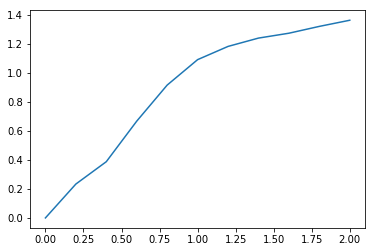

In [227]:
plt.plot(time,rmsd[2])

#### Surfactant head MSD

In [148]:
rmsd = rms_surfactant_head_list[0].rmsd.T   # transpose makes it easier for plotting
time = rmsd[1]

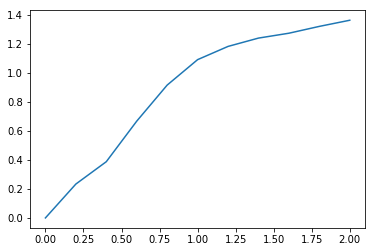

In [149]:
plt.plot(time,rmsd[2])

#### Au-S (substrate - head group ) RDF

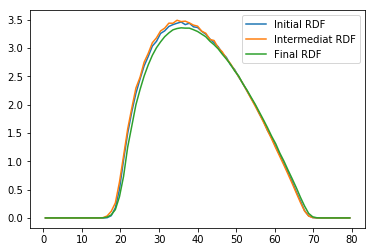

In [151]:
# indicates desired approach towards substrate
plt.plot(bins[0],rdf[0],label="Initial RDF")
plt.plot(bins[3],rdf[4],label="Intermediat RDF")
plt.plot(bins[-1],rdf[-1],label="Final RDF")
plt.legend()


### Pre-evaluated RDF

#### Overview

In [209]:
query = { 
    "metadata.project": project_id,
    "metadata.type": {'$regex': '.*rdf$'},
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

20

In [210]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [211]:
res_df

type                    earliest  \
0  surfactant_tail_surfactant_tail_rdf  2020-05-08 17:40:43.287019   
1  surfactant_head_surfactant_tail_rdf  2020-05-08 17:40:43.287016   
2  surfactant_head_surfactant_head_rdf  2020-05-08 17:40:43.287013   
3        substrate_surfactant_tail_rdf  2020-05-08 17:40:43.287011   
4        substrate_surfactant_head_rdf  2020-05-08 17:40:43.287008   
5              substrate_substrate_rdf  2020-05-08 17:40:43.287005   
6       counterion_surfactant_tail_rdf  2020-05-08 17:40:43.287003   
7       counterion_surfactant_head_rdf  2020-05-08 17:40:43.287000   
8             counterion_substrate_rdf  2020-05-08 17:40:43.286997   
9            counterion_counterion_rdf  2020-05-08 17:40:43.286995   

                       latest  object_count  
0  2020-05-08 20:09:19.747759             2  
1  2020-05-08 20:09:19.747755             2  
2  2020-05-08 20:09:19.747752             2  
3  2020-05-08 20:09:19.747745             2  
4  2020-05-08 20:09:19.747742             2  
5  2020-05-08 20:09:19.747739             2  
6  2020-05-08 20:09:19.747736             2  
7  2020-05-08 20:09:19.747733             2  
8  2020-05-08 20:09:19.747730             2  
9  2020-05-08 20:09:19.747727             2

#### Substrate - surfactant head RDF

In [212]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [213]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_head_rdf',
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

2

In [215]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

..


/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


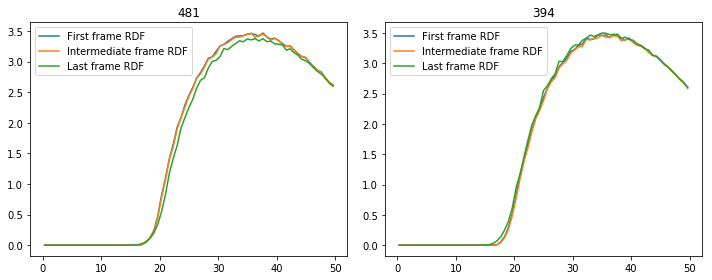

In [219]:
cols = 2
n = len(res_dict)
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

In [177]:
t = data[0]

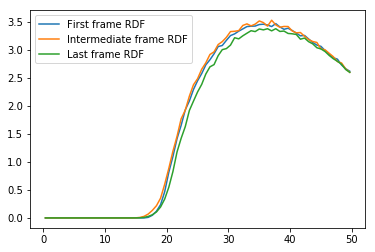

In [189]:
for nmolecules, data in res_dict.items():
    plt.plot(data[0],data[1],label='First frame RDF')
    plt.plot(data[0],data[len(data)//2],label='Intermediate frame RDF')
    plt.plot(data[0],data[-1],label='Last frame RDF')
    plt.legend()
    plt.show()

#### Substrate - surfactant tail RDF

In [190]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [195]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_tail_rdf',
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [196]:
res_list = []
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    res_list.append(data)
    print('.',end='')
print('')

.


In [197]:
t = data[0]

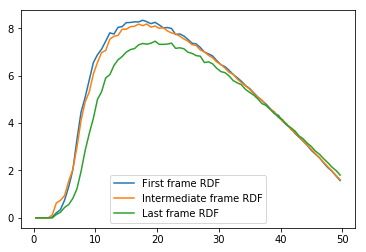

In [198]:
plt.plot(data[0],data[1],label='First frame RDF')
plt.plot(data[0],data[len(data)//2],label='Intermediate frame RDF')
plt.plot(data[0],data[-1],label='Last frame RDF')
plt.legend()
plt.show()

#### Surfactant head - surfactant tail RDF

In [199]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [200]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_tail_rdf',
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [201]:
res_list = []
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    res_list.append(data)
    print('.',end='')
print('')

.


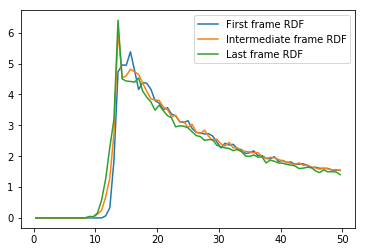

In [202]:
plt.plot(data[0],data[1],label='First frame RDF')
plt.plot(data[0],data[len(data)//2],label='Intermediate frame RDF')
plt.plot(data[0],data[-1],label='Last frame RDF')
plt.legend()
plt.show()

## Energy minimization after solvation analysis

### Overview on objects in step

In [237]:
project_id = '2020-05-08-final'

In [238]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad'
}

In [239]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

40

In [240]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [241]:
res_df

type  name                    earliest  \
0                              mp4_file   NaN  2020-05-08 17:40:43.297328   
1                  surfactant_tail_rmsd   NaN  2020-05-08 17:40:43.297326   
2                  surfactant_head_rmsd   NaN  2020-05-08 17:40:43.297323   
3                        substrate_rmsd   NaN  2020-05-08 17:40:43.297320   
4                       counterion_rmsd   NaN  2020-05-08 17:40:43.297318   
5   surfactant_tail_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.297315   
6   surfactant_head_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.297312   
7   surfactant_head_surfactant_head_rdf   NaN  2020-05-08 17:40:43.297310   
8         substrate_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.297307   
9         substrate_surfactant_head_rdf   NaN  2020-05-08 17:40:43.297305   
10              substrate_substrate_rdf   NaN  2020-05-08 17:40:43.297302   
11       counterion_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.297300   
12       counterion_surfactant_head_rdf   NaN  2020-05-08 17:40:43.297297   
13             counterion_substrate_rdf   NaN  2020-05-08 17:40:43.297294   
14            counterion_counterion_rdf   NaN  2020-05-08 17:40:43.297292   
15                        topology_file   NaN  2020-05-08 17:40:43.297289   
16                            data_file   NaN  2020-05-08 17:40:43.297287   
17                      trajectory_file   NaN  2020-05-08 17:40:43.297284   
18                          energy_file   NaN  2020-05-08 17:40:43.297281   
19                             log_file   NaN  2020-05-08 17:40:43.297276   

                        latest  object_count  
0   2020-05-08 20:09:19.760954             2  
1   2020-05-08 20:09:19.760949             2  
2   2020-05-08 20:09:19.760946             2  
3   2020-05-08 20:09:19.760943             2  
4   2020-05-08 20:09:19.760940             2  
5   2020-05-08 20:09:19.760937             2  
6   2020-05-08 20:09:19.760934             2  
7   2020-05-08 20:09:19.760931             2  
8   2020-05-08 20:09:19.760929             2  
9   2020-05-08 20:09:19.760926             2  
10  2020-05-08 20:09:19.760923             2  
11  2020-05-08 20:09:19.760920             2  
12  2020-05-08 20:09:19.760917             2  
13  2020-05-08 20:09:19.760914             2  
14  2020-05-08 20:09:19.760911             2  
15  2020-05-08 20:09:19.760908             2  
16  2020-05-08 20:09:19.760905             2  
17  2020-05-08 20:09:19.760902             2  
18  2020-05-08 20:09:19.760898             2  
19  2020-05-08 20:09:19.760892             2

### Global observables

In [242]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad',  #{'$regex': 'GromacsEnergyMinimization'}
    "metadata.type": 'energy_file',
}
fp.filepad.count_documents(query)

2

In [243]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [244]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [245]:
res_mi_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        em_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),em_df.index],
            names=[*c["_id"].keys(),'step'])
        em_mi_df = em_df.set_index(mi)        
        res_mi_list.append(em_mi_df)
    print('.',end='')
print('')

res_mi_df = pd.concat(res_mi_list)
res_df = res_mi_df.reset_index()

..


In [246]:
res_mi_df

Time        Bond           U-B   Proper Dih.  \
nmolecules step                                                       
481        0.0          0.0  145.184052  41074.089844  14150.828125   
           1.0          1.0  145.178436  41073.738281  14150.831055   
           2.0          2.0  145.208878  41073.304688  14150.839844   
           3.0          3.0  145.292740  41072.777344  14150.847656   
           4.0          4.0  145.471191  41072.128906  14150.853516   
...                     ...         ...           ...           ...   
394        9996.0    9996.0  463.388519  30225.587891  10935.462891   
           9997.0    9997.0  463.782410  30223.964844  10935.455078   
           9998.0    9998.0  464.670105  30226.169922  10935.450195   
           9999.0    9999.0  465.533112  30223.884766  10935.444336   
           10000.0  10000.0  467.347076  30227.121094  10935.439453   

                          LJ-14     Coulomb-14        LJ (SR)  Coulomb (SR)  \
nmolecules step                                                               
481        0.0      3404.288086  124293.343750  957347.500000   -3719528.75   
           1.0      3404.555908  124293.734375  955201.125000   -3719545.00   
           2.0      3404.882080  124294.195312  952620.562500   -3719565.25   
           3.0      3405.279541  124294.750000  949510.125000   -3719589.75   
           4.0      3405.764404  124295.453125  945762.562500   -3719620.25   
...                         ...            ...            ...           ...   
394        9996.0   2574.961670  101883.976562 -134320.218750   -4571061.00   
           9997.0   2574.455322  101883.531250 -134318.468750   -4571064.00   
           9998.0   2575.065186  101884.062500 -134317.390625   -4571071.50   
           9999.0   2574.340332  101883.429688 -134315.546875   -4571074.00   
           10000.0  2575.224121  101884.218750 -134314.687500   -4571081.50   

                    Coul. recip.  Position Rest.  ...    Pres-XY    Pres-XZ  \
nmolecules step                                   ...                         
481        0.0      42491.699219        0.241854  ...  38.816761  62.574196   
           1.0      42491.234375        0.241936  ...  38.694813  62.409492   
           2.0      42490.726562        0.242212  ...  38.547428  62.211441   
           3.0      42490.183594        0.242815  ...  38.370022  61.973263   
           4.0      42489.394531        0.243935  ...  38.156612  61.688419   
...                          ...             ...  ...        ...        ...   
394        9996.0    6468.461914     3354.836670  ...  -2.600663  15.032626   
           9997.0    6468.936523     3354.850586  ...  -2.600837  15.032550   
           9998.0    6468.379395     3354.864746  ...  -2.601012  15.032417   
           9999.0    6469.012695     3354.879395  ...  -2.601192  15.032320   
           10000.0   6468.214355     3354.891602  ...  -2.601346  15.032183   

                      Pres-YX     Pres-YY    Pres-YZ    Pres-ZX    Pres-ZY  \
nmolecules step                                                              
481        0.0      38.816772 -281.495911 -34.386101  62.574196 -34.386101   
           1.0      38.694820 -281.521637 -34.427864  62.409492 -34.427868   
           2.0      38.547421 -281.552704 -34.475567  62.211445 -34.475567   
           3.0      38.370026 -281.589417 -34.530651  61.973278 -34.530651   
           4.0      38.156612 -281.632599 -34.594276  61.688412 -34.594280   
...                       ...         ...        ...        ...        ...   
394        9996.0   -2.600664 -399.386963  -9.738742  15.032629  -9.738743   
           9997.0   -2.600840 -399.387939  -9.738904  15.032555  -9.738903   
           9998.0   -2.601014 -399.388428  -9.738994  15.032417  -9.738998   
           9999.0   -2.601191 -399.389435  -9.739044  15.032317  -9.739042   
           10000.0  -2.601344 -399.389954  -9.739162  15.032180  -9.739164   

                       Pres-

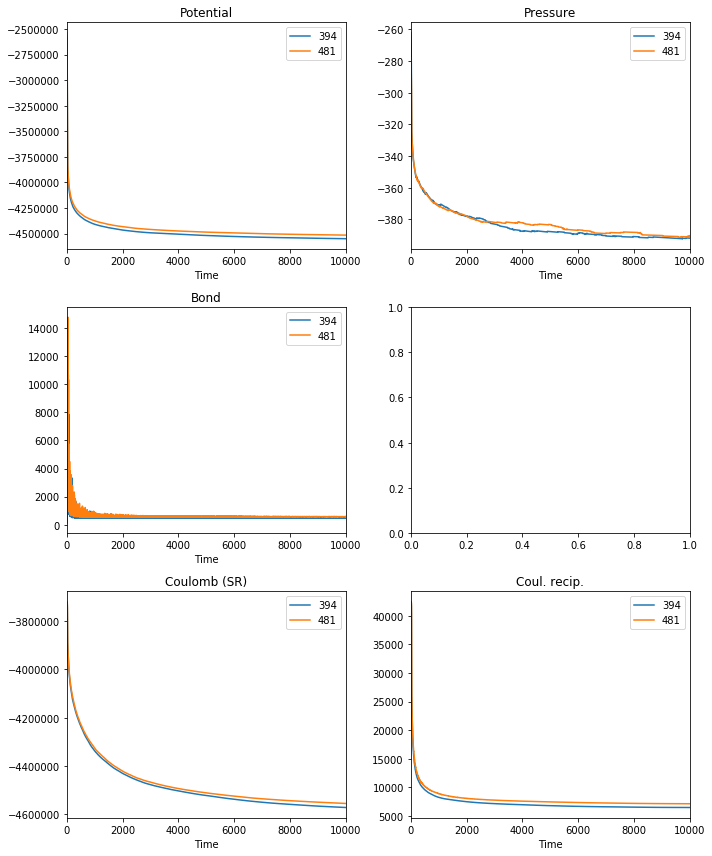

In [247]:
y_quantities = [
    'Potential',
    'Pressure',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

positions = [
    (0,0),
    (0,1),
    (1,0),
    (2,0),
    (2,1),
]
fig, ax = plt.subplots(3,2,figsize=(10,12))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

###  Rendered videos

In [260]:
project_id = '2020-05-08-final'

In [261]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [262]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

2

In [266]:
# check

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'nmolecules': '$metadata.system.surfactant.nmolecules'
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

# for i, c in enumerate(cursor): 
#    content, metadata = fp.get_file_by_id(c["latest"])
#    nmolecules = int(c["_id"]["nmolecules"])
    

res = [ {**c['_id'], **c} for c in cursor]
columns = ['nmolecules', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [267]:
res_df

nmolecules  name                    earliest                      latest  \
0         394   NaN  2020-05-08 20:09:19.760954  2020-05-08 20:09:19.760954   
1         481   NaN  2020-05-08 17:40:43.297328  2020-05-08 17:40:43.297328   

   object_count  
0             1  
1             1

In [270]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        obj_dict.update({metadata['metadata']['system']['surfactant']['nmolecules']: Video.from_file(tmp.name)})
    print('.',end='')

..

In [271]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

481


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05\xd0pmdat\x00\x…

394


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05\xf6Bmdat\x00\x…

### Trajectory

In [243]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad',
    "metadata.type":    { '$in': ['trajectory_file','data_file'] },
}
fp.filepad.count_documents(query)

2

In [244]:
# Building a rather sophisticated aggregation pipeline

# first group by nmolecules and type ...

parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules',
    'type': 'metadata.type'}
# parameter_names = ['nmolecules', 'type']

query = { 
    "metadata.project": project_id,
    "metadata.type":    { '$in': ['trajectory_file','data_file'] },
}

aggregation_pipeline = []

aggregation_pipeline.append({ 
    "$match": query
})

aggregation_pipeline.append({ 
    "$sort": { 
        "metadata.system.surfactant.nmolecules": pymongo.ASCENDING,
        "metadata.datetime": pymongo.DESCENDING,
    }
})

aggregation_pipeline.append({ 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
})

# second group by nmolecules

parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

aggregation_pipeline.append({ 
    "$group": { 
        "_id": { field: '$_id.{}'.format(field) for field in parameter_dict.keys() },
        "type":     {"$addToSet": "$_id.type"},
        "gfs_id":   {"$addToSet": "$latest"} 
        #"$_id.type": "$latest"
    }
})

aggregation_pipeline.append({
    '$project': {
         '_id': False,
        **{field: '$_id.{}'.format(field) for field in parameter_dict.keys()},
        'objects': { 
            '$zip': {
                'inputs': [ '$type', '$gfs_id' ],
                'useLongestLength': True,
                'defaults':  [None,None]
            }
        }
    }
})

aggregation_pipeline.append({ 
    '$project': {
        **{p: True for p in parameter_dict.keys()},
        'objects': {'$arrayToObject': '$objects'}
        #'objects': False 
    }
})

aggregation_pipeline.append({ 
    '$addFields': {
        'objects': {**{ field: '${}'.format(field) for field in parameter_dict.keys()}}
    }
})

aggregation_pipeline.append({ 
    '$replaceRoot': { 'newRoot': '$objects' }
})

# display results with
# for i, c in enumerate(cursor): 
#    print(c)
# yields documents in the form
# {'em_solvated_gro': '5e6a4e3d6c26f976ceae5e38', 'em_solvated_trr': '5e6a4e3a6c26f976ceae5e14', 'nmolecules': '44'}
# i.e. most recent topology file and trajectory file per concentration

cursor = fp.filepad.aggregate(aggregation_pipeline)

mda_trr_list = []
for i, c in enumerate(cursor): 
    em_gro_content, _ = fp.get_file_by_id(c["data_file"])
    em_trr_content, _ = fp.get_file_by_id(c["trajectory_file"])
    # Stream approach won't work
    # with io.TextIOWrapper( io.BytesIO(em_gro_content) ) as gro, \
    #    io.BytesIO(em_trr_content) as trr:   
        #mda_trr_list.append( 
        #    mda.Universe( 
        #        gro,trr, topology_format = 'GRO', format='TRR') )
    with tempfile.NamedTemporaryFile(suffix='.gro') as gro, \
        tempfile.NamedTemporaryFile(suffix='.trr') as trr:
        gro.write(em_gro_content)
        trr.write(em_trr_content)
        mda_trr_list.append( mda.Universe(gro.name,trr.name) )
    print('.',end='')
print('')

.


In [245]:
mda_trr = mda_trr_list[0]
# check unique resiude names in system
resnames = np.unique([ r.resname for r in mda_trr.residues ])

In [246]:
resnames

array(['AUM', 'NA', 'SDS', 'SOL'], dtype='<U3')

In [247]:
mda_view = nglview.show_mdanalysis(mda_trr)

# setSize: https://cloud.githubusercontent.com/assets/22888066/21761120/e47e2988-d68b-11e6-9e11-a894d7833d50.png
mda_view._remote_call('setSize', target='Widget', args=['600px','600px'])

mda_view.clear_representations()
mda_view.background = 'white'
mda_view.add_representation(repr_type='ball+stick',selection='SDS')
mda_view.add_representation(repr_type='ball+stick',selection='NA')
mda_view.add_representation(repr_type='spacefill',selection='AUM',color='yellow')
mda_view.center()
mda_view

NGLWidget(max_frame=100)

#### Render images

In [248]:
len(mda_trr.trajectory)

101

In [68]:
# https://ambermd.org/tutorials/analysis/tutorial_notebooks/nglview_movie/index.html
    
# make sure to change your web browser option to save files as default (vs open file by external program)
# NGLView will render each snapshot and save image to your web browser default download location
# uncomment all the commands below to render

from time import sleep

# # to save time for this tutorial, we make a movie with only 50 frames
for frame in range(0, len(mda_trr.trajectory)):
     # set frame to update coordinates
    mda_view.frame = frame
    # make sure to let NGL spending enough time to update coordinates
    sleep(0.5)
    mda_view.download_image(filename='frame{:04d}.png'.format(frame))
    # make sure to let NGL spending enough time to render before going to next frame
    sleep(2.0)

In [ ]:
# ffmpeg -r 20 -f image2 -i frame%04d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p out.mp4

#### Render gif

In [44]:
from nglview.contrib.movie import MovieMaker

In [50]:
output_folder = os.path.join(work_prefix,'mov')

In [52]:
try:
    os.mkdir(output_folder)
except FileExistsError as exc:
    print(exc)

In [64]:
mov = MovieMaker(
    mda_view, download_folder=output_folder, output="em_solvated.gif")

In [65]:
mov.make()

IntProgress(value=0, description='Rendering ...', max=79)

#### Make avi

In [66]:
# write avi format
from nglview.contrib.movie import MovieMaker
moviepy_params = {
     'codec': 'mpeg4'
}
movie = MovieMaker(mda_view, output='em_solvated.avi', in_memory=True, moviepy_params=moviepy_params)
movie.make()

IntProgress(value=0, description='Rendering ...', max=79)

Again, relax the system a little with positional constraints applied to all ions.

## NVT equilibration analysis

### Overview on objects in step

In [272]:
project_id = '2020-05-08-final'

In [273]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNVTEquilibration:ProcessAnalyzeAndVisualize:push_filepad'
}

In [274]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

42

In [275]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [276]:
res_df

type  name                    earliest  \
0                              mp4_file   NaN  2020-05-08 17:40:43.307627   
1                  surfactant_tail_rmsd   NaN  2020-05-08 17:40:43.307625   
2                  surfactant_head_rmsd   NaN  2020-05-08 17:40:43.307622   
3                        substrate_rmsd   NaN  2020-05-08 17:40:43.307619   
4                       counterion_rmsd   NaN  2020-05-08 17:40:43.307617   
5   surfactant_tail_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.307614   
6   surfactant_head_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.307611   
7   surfactant_head_surfactant_head_rdf   NaN  2020-05-08 17:40:43.307609   
8         substrate_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.307606   
9         substrate_surfactant_head_rdf   NaN  2020-05-08 17:40:43.307604   
10              substrate_substrate_rdf   NaN  2020-05-08 17:40:43.307601   
11       counterion_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.307599   
12       counterion_surfactant_head_rdf   NaN  2020-05-08 17:40:43.307596   
13             counterion_substrate_rdf   NaN  2020-05-08 17:40:43.307593   
14            counterion_counterion_rdf   NaN  2020-05-08 17:40:43.307591   
15                           index_file   NaN  2020-05-08 17:40:43.307588   
16                        topology_file   NaN  2020-05-08 17:40:43.307586   
17                            data_file   NaN  2020-05-08 17:40:43.307583   
18                      trajectory_file   NaN  2020-05-08 17:40:43.307580   
19                          energy_file   NaN  2020-05-08 17:40:43.307578   
20                             log_file   NaN  2020-05-08 17:40:43.307572   

                        latest  object_count  
0   2020-05-08 20:09:19.773631             2  
1   2020-05-08 20:09:19.773628             2  
2   2020-05-08 20:09:19.773625             2  
3   2020-05-08 20:09:19.773622             2  
4   2020-05-08 20:09:19.773618             2  
5   2020-05-08 20:09:19.773613             2  
6   2020-05-08 20:09:19.773608             2  
7   2020-05-08 20:09:19.773605             2  
8   2020-05-08 20:09:19.773602             2  
9   2020-05-08 20:09:19.773599             2  
10  2020-05-08 20:09:19.773596             2  
11  2020-05-08 20:09:19.773593             2  
12  2020-05-08 20:09:19.773590             2  
13  2020-05-08 20:09:19.773587             2  
14  2020-05-08 20:09:19.773584             2  
15  2020-05-08 20:09:19.773582             2  
16  2020-05-08 20:09:19.773579             2  
17  2020-05-08 20:09:19.773576             2  
18  2020-05-08 20:09:19.773572             2  
19  2020-05-08 20:09:19.773569             2  
20  2020-05-08 20:09:19.773563             2

### Global observables

In [278]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsNVTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

2

In [279]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [280]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [281]:
[ c for c in cursor]

[{'_id': {'nmolecules': 481},
  'degeneracy': 1,
  'latest': '5eb59325c35b03917330988a'},
 {'_id': {'nmolecules': 394},
  'degeneracy': 1,
  'latest': '5eb5ee6fc61194c216bd5ef8'}]

In [289]:
res_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

..


In [290]:
res_df.columns

Index(['nmolecules', 'step', 'Time', 'Bond', 'U-B', 'Proper Dih.', 'LJ-14',
       'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)', 'Coul. recip.', 'Potential',
       'Kinetic En.', 'Total Energy', 'Conserved En.', 'Temperature',
       'Pressure', 'Constr. rmsd', 'Vir-XX', 'Vir-XY', 'Vir-XZ', 'Vir-YX',
       'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY', 'Vir-ZZ', 'Pres-XX', 'Pres-XY',
       'Pres-XZ', 'Pres-YX', 'Pres-YY', 'Pres-YZ', 'Pres-ZX', 'Pres-ZY',
       'Pres-ZZ', '#Surf*SurfTen', 'T-non-Substrate', 'T-Substrate',
       'Lamb-non-Substrate', 'Lamb-Substrate'],
      dtype='object')

In [307]:
res_df_mi

Time         Bond           U-B   Proper Dih.        LJ-14  \
nmolecules step                                                                 
481        0.0      0.0   719.858704  36907.792969  13090.259766  3120.402588   
           1.0      1.0  6624.424316  64571.613281  17391.203125  4301.584961   
           2.0      2.0  7460.250000  70421.539062  18345.968750  4570.080078   
           3.0      3.0  8053.640625  72889.289062  18875.626953  4733.014160   
           4.0      4.0  8538.462891  75404.414062  18983.947266  4927.416504   
...                 ...          ...           ...           ...          ...   
394        96.0    96.0  6952.033691  62679.117188  15624.823242  3952.249756   
           97.0    97.0  6979.172852  62487.980469  15418.816406  3943.986572   
           98.0    98.0  6961.317383  62311.750000  15375.333984  3931.924316   
           99.0    99.0  7008.983398  62150.246094  15282.997070  4028.713623   
           100.0  100.0  6706.490234  62571.292969  15278.705078  3961.557129   

                     Coulomb-14        LJ (SR)  Coulomb (SR)  Coul. recip.  \
nmolecules step                                                              
481        0.0    124511.843750 -148637.687500   -4554217.00   7135.504395   
           1.0    123490.445312 -205062.125000   -4108750.50   7570.643555   
           2.0    123333.093750 -223882.171875   -4015081.25   9305.986328   
           3.0    122939.187500 -243196.984375   -3937349.00   9741.042969   
           4.0    123162.500000 -258399.703125   -3879562.25  10166.835938   
...                         ...            ...           ...           ...   
394        96.0    96029.867188 -289660.437500   -3708112.25  10705.315430   
           97.0    96425.257812 -290708.437500   -3707258.25  10758.857422   
           98.0    96092.812500 -290332.937500   -3707167.25  10983.360352   
           99.0    96534.437500 -289030.750000   -3709194.00  10863.829102   
           100.0   96110.640625 -289786.750000   -3707068.00  10961.282227   

                   Potential  ...      Pres-YY    Pres-YZ     Pres-ZX  \
nmolecules step               ...                                       
481        0.0   -4517369.00  ...  -370.612427  85.380737  157.510666   
           1.0   -4089862.75  ...  1512.856689 -46.191006  -21.177368   
           2.0   -4005526.50  ...  1958.089966  -7.224908  -23.616018   
           3.0   -3943314.00  ...  2122.161621  18.075472  -38.445389   
           4.0   -3896778.50  ...  2228.779053  -5.308508  -16.367617   
...                      ...  ...          ...        ...         ...   
394        96.0  -3801829.25  ...  2432.029541  -9.029548  -61.607548   
           97.0  -3801952.75  ...  2417.126221  -4.024414    2.195028   
           98.0  -3801843.75  ...  2565.019775  -1.286788  -10.624902   
           99.0  -3802355.50  ...  2512.904785  45.250336   24.462406   
           100.0 -3801264.75  ...  2453.535889  57.717255  -48.329845   

                    Pres-ZY      Pres-ZZ  #Surf*SurfTen  T-non-Substrate  \
nmolecules step                                                            
481        0.0    83.235252   472.725128    8314.196289       298.303619   
           1.0   -46.252201  1662.894897    1301.035889       207.926895   
           2.0   -10.072059  1937.901855    -369.082336       238.926559   
           3.0    18.511299  2218.974854    1697.637573       256.758759   
           4.0    -5.606668  2220.199951     597.782104       268.111145   
...                     ...          ...            ...              ...   
394        96.0  -12.355177  2543.938477    1976.498047       296.839752   
           97.0   -4.814836  2528.283691    1913.367920       298.581848   
           98.0    1.401115  2468.132568    -527.862122       298.448883   
           99.0   46.825481  2419.751953   -1197.856445       298.333069   
           100.0  60.130989  2498.999023     626.274048       298.086884   

           

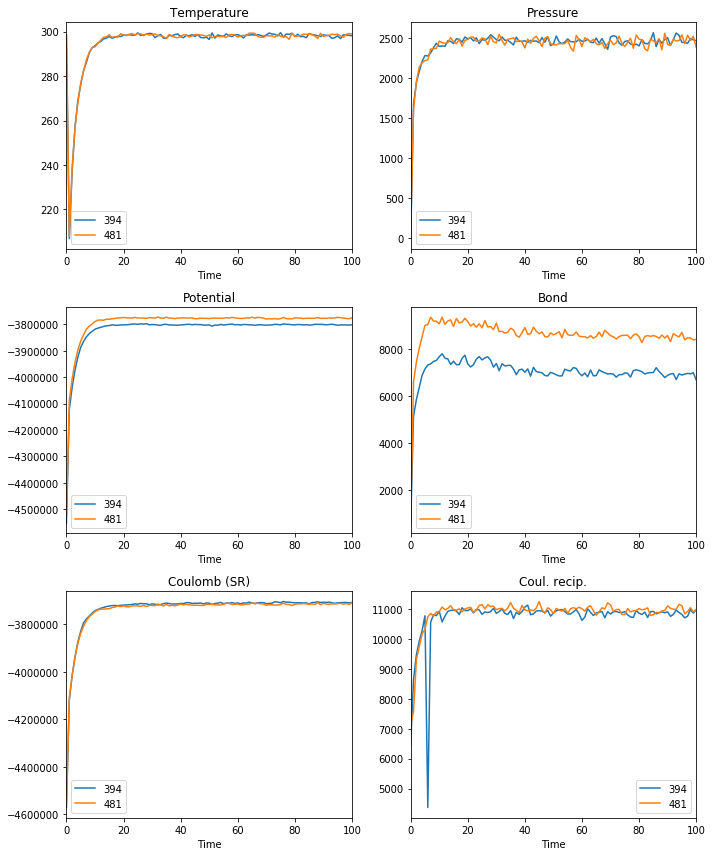

In [293]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [294]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNVTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [295]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

2

In [303]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

..

In [306]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

(481,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00)\x1c\x80mdat\x00\x…

(394,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00&\x8e?mdat\x00\x00\…

## NPT equilibration analysis

### Overview on objects in step

In [308]:
project_id = '2020-05-08-final'

In [309]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad'
}

In [310]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

42

In [311]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [312]:
res_df

type  name                    earliest  \
0                              mp4_file   NaN  2020-05-08 17:40:43.318432   
1                  surfactant_tail_rmsd   NaN  2020-05-08 17:40:43.318429   
2                  surfactant_head_rmsd   NaN  2020-05-08 17:40:43.318426   
3                        substrate_rmsd   NaN  2020-05-08 17:40:43.318424   
4                       counterion_rmsd   NaN  2020-05-08 17:40:43.318421   
5   surfactant_tail_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.318418   
6   surfactant_head_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.318416   
7   surfactant_head_surfactant_head_rdf   NaN  2020-05-08 17:40:43.318413   
8         substrate_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.318411   
9         substrate_surfactant_head_rdf   NaN  2020-05-08 17:40:43.318408   
10              substrate_substrate_rdf   NaN  2020-05-08 17:40:43.318405   
11       counterion_surfactant_tail_rdf   NaN  2020-05-08 17:40:43.318403   
12       counterion_surfactant_head_rdf   NaN  2020-05-08 17:40:43.318400   
13             counterion_substrate_rdf   NaN  2020-05-08 17:40:43.318398   
14            counterion_counterion_rdf   NaN  2020-05-08 17:40:43.318395   
15                           index_file   NaN  2020-05-08 17:40:43.318392   
16                        topology_file   NaN  2020-05-08 17:40:43.318390   
17                            data_file   NaN  2020-05-08 17:40:43.318387   
18                      trajectory_file   NaN  2020-05-08 17:40:43.318385   
19                          energy_file   NaN  2020-05-08 17:40:43.318381   
20                             log_file   NaN  2020-05-08 17:40:43.318376   

                        latest  object_count  
0   2020-05-08 20:09:19.785964             2  
1   2020-05-08 20:09:19.785961             2  
2   2020-05-08 20:09:19.785958             2  
3   2020-05-08 20:09:19.785955             2  
4   2020-05-08 20:09:19.785952             2  
5   2020-05-08 20:09:19.785949             2  
6   2020-05-08 20:09:19.785946             2  
7   2020-05-08 20:09:19.785943             2  
8   2020-05-08 20:09:19.785940             2  
9   2020-05-08 20:09:19.785937             2  
10  2020-05-08 20:09:19.785934             2  
11  2020-05-08 20:09:19.785931             2  
12  2020-05-08 20:09:19.785928             2  
13  2020-05-08 20:09:19.785925             2  
14  2020-05-08 20:09:19.785922             2  
15  2020-05-08 20:09:19.785919             2  
16  2020-05-08 20:09:19.785916             2  
17  2020-05-08 20:09:19.785913             2  
18  2020-05-08 20:09:19.785910             2  
19  2020-05-08 20:09:19.785906             2  
20  2020-05-08 20:09:19.785900             2

### Global observables

In [313]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

2

In [314]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [315]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [316]:
[ c for c in cursor]

[{'_id': {'nmolecules': 481},
  'degeneracy': 1,
  'latest': '5eb59880c35b03917330a539'},
 {'_id': {'nmolecules': 394},
  'degeneracy': 1,
  'latest': '5eb5f3dfc61194c216bd6bac'}]

In [317]:
res_list = []

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

..


In [318]:
res_df.columns

Index(['nmolecules', 'step', 'Time', 'Bond', 'U-B', 'Proper Dih.', 'LJ-14',
       'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)', 'Coul. recip.', 'Potential',
       'Kinetic En.', 'Total Energy', 'Conserved En.', 'Temperature',
       'Pressure', 'Constr. rmsd', 'Box-X', 'Box-Y', 'Box-Z', 'Volume',
       'Density', 'pV', 'Enthalpy', 'Vir-XX', 'Vir-XY', 'Vir-XZ', 'Vir-YX',
       'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY', 'Vir-ZZ', 'Pres-XX', 'Pres-XY',
       'Pres-XZ', 'Pres-YX', 'Pres-YY', 'Pres-YZ', 'Pres-ZX', 'Pres-ZY',
       'Pres-ZZ', '#Surf*SurfTen', 'Box-Vel-XX', 'Box-Vel-YY', 'Box-Vel-ZZ',
       'Coul-SR:Surfactant-Surfactant', 'LJ-SR:Surfactant-Surfactant',
       'Coul-14:Surfactant-Surfactant', 'LJ-14:Surfactant-Surfactant',
       'Coul-SR:Surfactant-Substrate', 'LJ-SR:Surfactant-Substrate',
       'Coul-14:Surfactant-Substrate', 'LJ-14:Surfactant-Substrate',
       'Coul-SR:Surfactant-Ion', 'LJ-SR:Surfactant-Ion',
       'Coul-14:Surfactant-Ion', 'LJ-14:Surfactant-Ion',
      

In [319]:
res_df_mi

Time         Bond           U-B   Proper Dih.        LJ-14  \
nmolecules step                                                                 
481        0.0      0.0  8551.705078  76494.312500  19150.726562  4873.254395   
           1.0      1.0  8553.014648  75683.148438  19050.751953  4929.570312   
           2.0      2.0  8599.532227  75477.656250  18924.519531  4820.133789   
           3.0      3.0  8533.779297  76001.765625  18964.052734  4900.325195   
           4.0      4.0  8504.189453  76643.156250  18897.892578  4714.265137   
...                 ...          ...           ...           ...          ...   
394        96.0    96.0  6761.270508  63241.664062  15624.504883  3976.773926   
           97.0    97.0  7106.312500  62602.324219  15759.688477  3847.831299   
           98.0    98.0  6862.751465  62495.914062  15613.023438  3973.201172   
           99.0    99.0  6926.183594  62550.351562  15493.875000  3900.743408   
           100.0  100.0  6839.876465  62812.113281  15435.979492  3843.076660   

                     Coulomb-14       LJ (SR)  Coulomb (SR)  Coul. recip.  \
nmolecules step                                                             
481        0.0    117386.710938 -302998.87500   -3709636.00  11389.068359   
           1.0    117642.867188 -315079.59375   -3691032.25   9378.003906   
           2.0    117413.726562 -327499.03125   -3667862.25  11508.069336   
           3.0    117664.320312 -321425.65625   -3664991.00  11968.698242   
           4.0    117041.234375 -315199.90625   -3669027.75  11905.316406   
...                         ...           ...           ...           ...   
394        96.0    95716.359375 -304561.18750   -3699204.25  11173.559570   
           97.0    95482.601562 -300428.46875   -3703083.25  11229.029297   
           98.0    95480.054688 -301234.50000   -3703111.50  11145.840820   
           99.0    95529.039062 -299181.87500   -3703019.00  11312.145508   
           100.0   95668.156250 -302185.09375   -3700540.75  11212.008789   

                   Potential  ...  Coul-14:Ion-SOL  LJ-14:Ion-SOL  \
nmolecules step               ...                                   
481        0.0   -3774789.25  ...              0.0            0.0   
           1.0   -3770874.50  ...              0.0            0.0   
           2.0   -3758617.75  ...              0.0            0.0   
           3.0   -3748383.50  ...              0.0            0.0   
           4.0   -3746521.75  ...              0.0            0.0   
...                      ...  ...              ...            ...   
394        96.0  -3807271.25  ...              0.0            0.0   
           97.0  -3807484.00  ...              0.0            0.0   
           98.0  -3808775.25  ...              0.0            0.0   
           99.0  -3806488.50  ...              0.0            0.0   
           100.0 -3806914.50  ...              0.0            0.0   

                  Coul-SR:SOL-SOL  LJ-SR:SOL-SOL  Coul-14:SOL-SOL  \
nmolecules step                                                     
481        0.0        -3220008.00   321678.71875              0.0   
           1.0        -3199992.25   316848.34375              0.0   
           2.0        -3178096.00   308713.25000              0.0   
           3.0        -3175896.00   314308.68750              0.0   
           4.0        -3179593.50   320332.84375              0.0   
...                           ...            ...              ...   
394        96.0       -3274411.00   327309.00000              0.0   
           97.0       -3278301.00   331073.56250              0.0   
           98.0       -3277002.75   330121.90625              0.0   
           99.0       -3277595.75   332388.68750              0.0   
           100.0      -3274412.50   329459.00000              0.0   

                  LJ-14:SOL-SOL  T-non-Substrate  T-Substrate  \
nmolecules step                                                 
481        0.0              0.0      

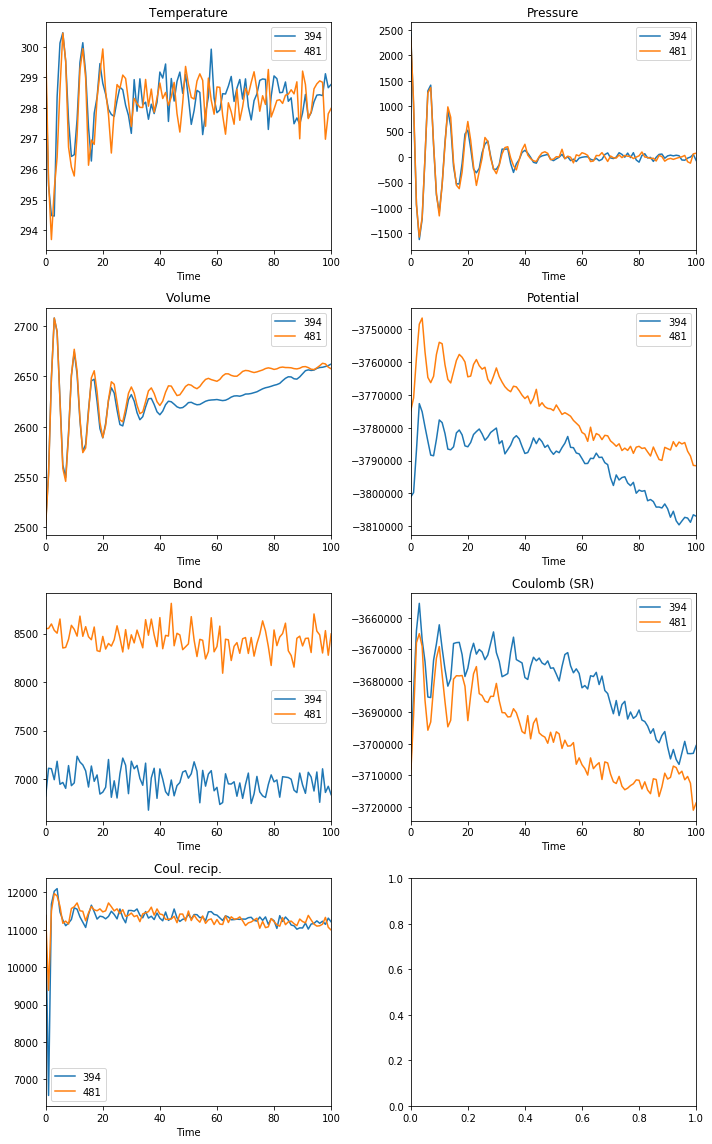

In [320]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Volume',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [325]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [326]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

2

In [327]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

..

In [328]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

(481,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00,%7mdat\x00\x00\x02…

(394,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00$Z\x1bmdat\x00\x00\…

### Global observables

### Visualize trajectory

In [61]:
mda_trr = mda.Universe('nvt.gro','npt.trr')

/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [62]:
# check unique resiude names in system
resnames = np.unique([ r.resname for r in mda_trr.residues ])

In [63]:
resnames

array(['AUM', 'NA', 'SDS', 'SOL'], dtype='<U3')

In [64]:
mda_view = nglview.show_mdanalysis(mda_trr)
mda_view.clear_representations()
mda_view.background = 'white'
mda_view.add_representation(repr_type='ball+stick',selection='SDS')
mda_view.add_representation(repr_type='ball+stick',selection='NA')
mda_view.add_representation(repr_type='spacefill',selection='AUM',color='yellow')
mda_view.center()

/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


In [65]:
mda_view

NGLWidget(count=101)

In [67]:
substrate = mda_trr.select_atoms('resname AUM')

In [103]:
substrate.masses= ase.data.atomic_masses[ase.data.atomic_numbers['Au']]

In [105]:
substrtate_com_traj = np.array([substrate.center_of_mass() for ts in mda_trr.trajectory ])

In [106]:
substrtate_rgyr_traj = np.array([substrate.radius_of_gyration() for ts in mda_trr.trajectory ])

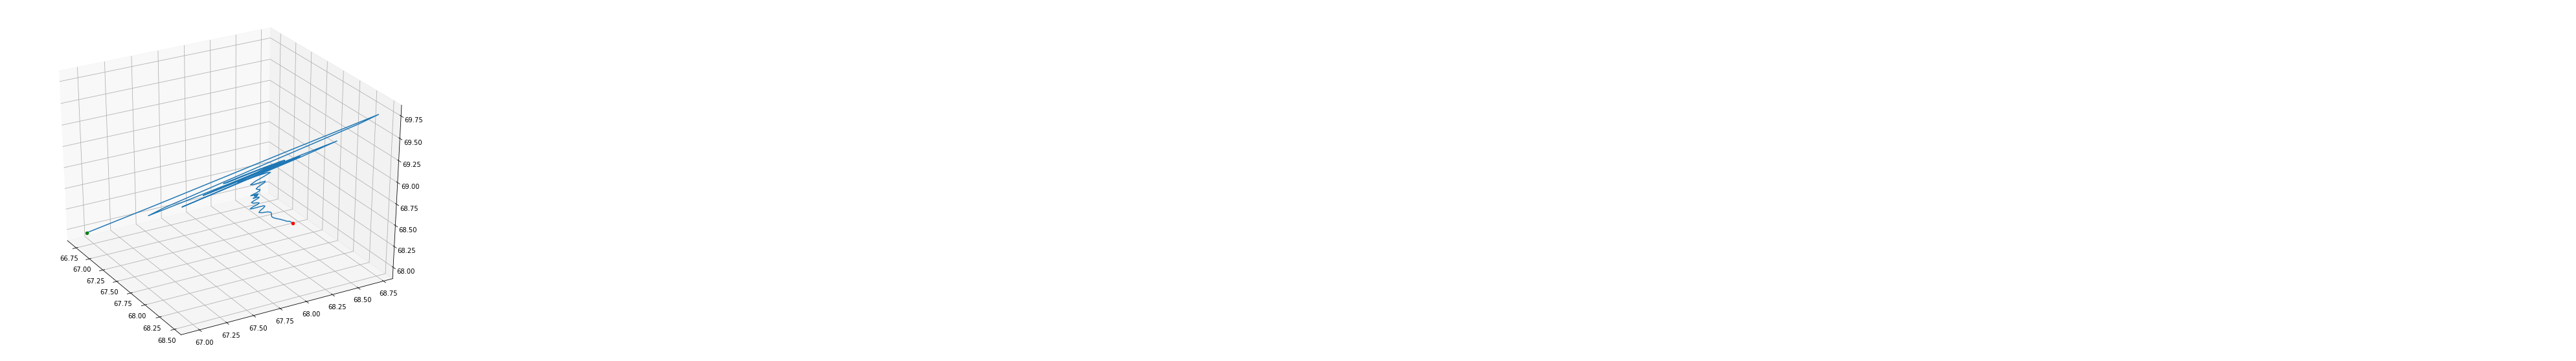

In [107]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d',azim=-30)
ax.plot(*substrtate_com_traj.T)
ax.scatter(*substrtate_com_traj[0,:],color='green')
ax.scatter(*substrtate_com_traj[-1,:],color='red')

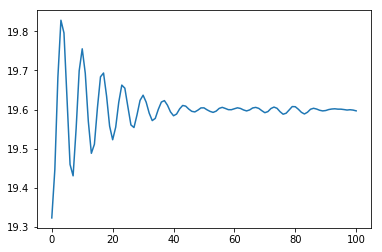

In [109]:
plt.plot(substrtate_rgyr_traj)

In [119]:
try:
    del mda_trr
except:
    pass
try:
    del mda_view
except:
    pass